In [1]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [19]:
# data-relevant constants
DF = pd.read_csv('../data/main_table_S82.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'
NUM_NORMS = 800

In [20]:
# plot fontsize settings

SMALL_FONT_SIZE = 16
MEDIUM_FONT_SIZE = 20
LARGE_FONT_SIZE = 20

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [21]:
# line properties

PROPS = {
    'sdss_raw': { 'color': '#AAAAAA', 'ls': '--', 'lw': 1, 'label': 'SDSS flux' },
    'gaussian': { 'color': '#FF4444', 'ls': '-', 'lw': 2, 'label': 'Gaussian fit to SDSS flux' },
    'gaia': {'color': '#4444FF', 'ls': '-', 'lw': 2, 'label': 'Gaia flux' }
}

In [22]:
def plot_w_props(x, y, props):
    plt.plot(x, y, color=props['color'], ls=props['ls'], lw=props['lw'], label=props['label'])

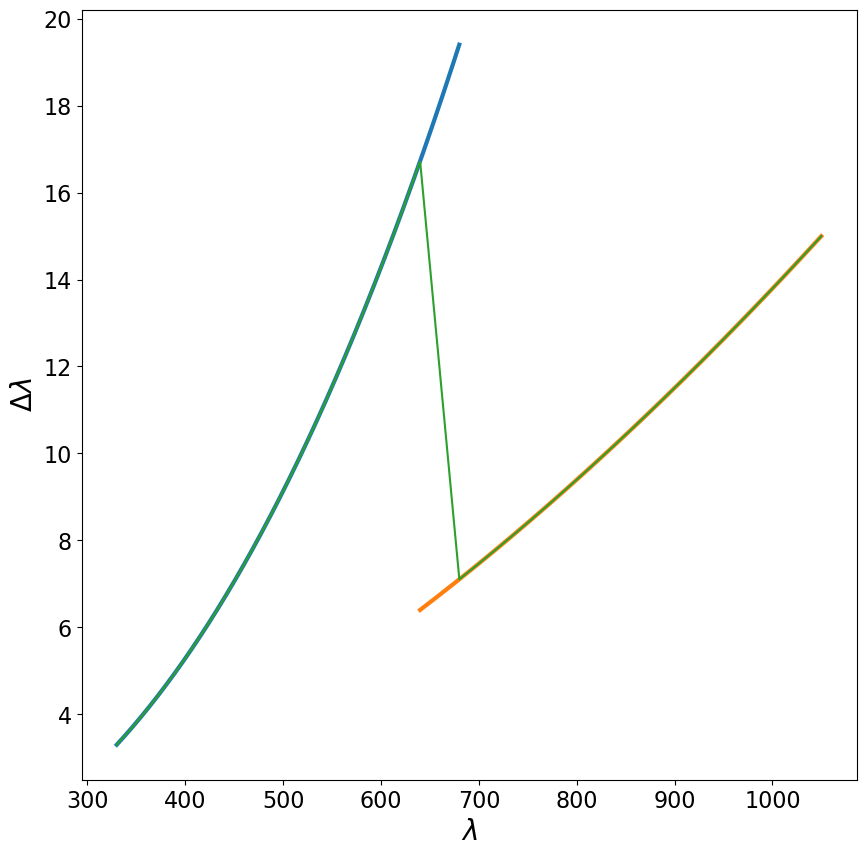

In [23]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
    y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
    return np.piecewise(wvl, \
                        [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
                        [y1, y_mid, y2])
#     return np.piecewise(wvl, \
#                         [wvl < 660, wvl >= 660], \
#                         [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, deltaXP(x))

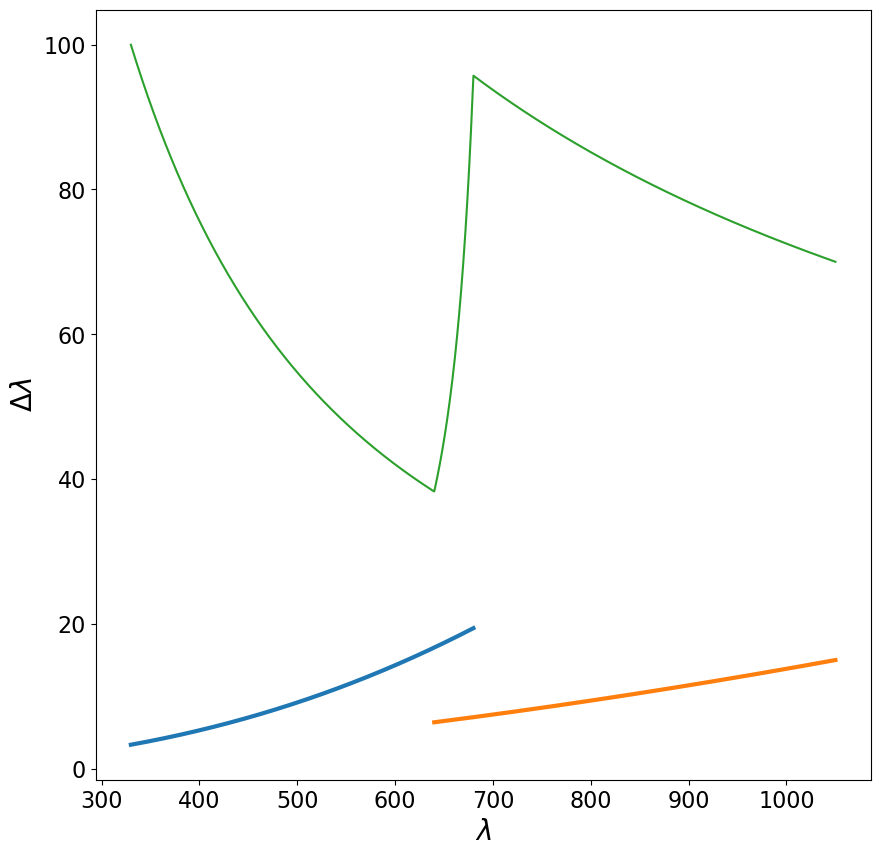

In [24]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
    y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
    return np.piecewise(wvl, \
                        [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
                        [y1, y_mid, y2])
#     return np.piecewise(wvl, \
#                         [wvl < 660, wvl >= 660], \
#                         [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, x/deltaXP(x))

In [25]:
def plot_conv(*, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # const (test)
#     sdss_flux = np.array([np.mean(sdss_flux)] * len(sdss_flux))
    
    # get gaia data and calibrate using sdss sampling
    gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]

    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
#     sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(locs)**2)  # convolve gaussian sigmas with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.mean(sdss_conv[mask]/gaia_flux[mask])

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, sdss_conv, PROPS['gaussian'])
    plot_w_props(sdss_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"gaussian fit rms error = {fit_rms:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.75, f"k = {k:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.7, f"sdss - gaia rms error = {match_rms:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.65, f"sdss/gaia quotient = {quot:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.6, f"integrated flux (raw) = {raw_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.55, f"integrated flux (fit) = {fit_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.5, f"integrated flux (conv) = {conv_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}_k_{int(k*10)}.png')
    plt.show()

In [26]:
def plot_conv_get_gaia(*, gaia_id=None, sdss_id=None):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # get gaia data and calibrate using sdss sampling
    while True:
        try:
            print('calibrating gaia...')
            gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]
            print('done.')
            return gaia_flux
        except Exception as e:
            print(e)
            continue

In [31]:
def plot_conv_k_rms(gaia_flux, *, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.median(sdss_conv/gaia_flux)

    return match_rms, quot

In [32]:
DF

,source_id,clean_sdssdr13_oid,original_ext_source_id,angular_distance,gaia_ra,gaia_dec,phot_g_mean_mag,bp_g,g_rp,objId,...,D_mean,D_std,D_median,D_rrms,nonvar_match_id,nonvar_match_num,var_match_id,var_match_num,quasar_match_id,quasar_match_num
0,4225501834985753344,57530724,1237656567037559338,0.011177,310.797097,-1.253772,16.467684,0.227772,0.379124,1237656567037559338,...,0.099155,0.058576,0.092913,0.069502,CALIBSTARS_0038958,1,NaN,0,NaN,0
1,4231366290706190848,87130941,1237656896139625770,0.454737,309.443909,1.208073,15.953631,0.665402,1.739179,1237656896139625770,...,0.378947,0.277165,0.262193,0.324390,NaN,0,NaN,0,NaN,0
2,4231368352291653248,87647545,1237656896139690368,0.026809,309.502781,1.253721,16.877040,0.463362,0.624773,1237656896139690368,...,0.034895,0.021277,0.033998,0.020770,NaN,0,NaN,0,NaN,0
3,4231459641820195072,86461503,1237659743703270094,0.159648,309.306050,1.146336,15.715158,0.473539,0.680981,1237659743703270094,...,0.042900,0.027878,0.040784,0.021712,NaN,0,NaN,0,NaN,0
4,4229627722304479744,70934794,1237663543136878919,0.053041,309.202870,-0.133755,16.131628,1.363316,1.181491,1237663543136878919,...,0.097228,0.064785,0.097361,0.064189,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13172,2449908757922377984,64869908,1237657190368149518,0.060885,359.531187,-0.621597,16.146488,0.305464,0.469759,1237657190368149518,...,0.030212,0.010212,0.030353,0.010917,CALIBSTARS_0669111,1,NaN,0,NaN,0
13173,2449915801668752256,66390159,1237657190368149535,0.069664,359.598322,-0.501605,16.818098,0.273106,0.468475,1237657190368149535,...,NaN,NaN,NaN,NaN,CALIBSTARS_0669120,1,NaN,0,NaN,0
13174,2449922158220347776,67940062,1237663783660355695,0.016039,359.623958,-0.370501,16.231474,0.943159,0.972342,1237663783660355695,...,0.050007,0.028397,0.052255,0.029286,CALIBSTARS_0667192,1,NaN,0,NaN,0
13175,2449930885593959680,67918300,1237663783660486851,0.011220,359.997024,-0.372143,16.040173,0.626829,0.795743,1237663783660486851,...,0.128049,0.047492,0.119451,0.041687,NaN,0,3884234.0,1,NaN,0


In [33]:
gaia_flux = plot_conv_get_gaia(gaia_id=4225501834985753344)
plot_conv_k_rms(gaia_flux, gaia_id=4225501834985753344, k=0.5)

calibrating gaia...


done.


(6.582577270910091e-19, 0.9100817067117607)

In [36]:
ks = {}
qs = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.20, 1.800001, 0.02):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks[gaia_id] = min_k
    qs[gaia_id] = min_q

  0%|                                                                           | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|                                                                 | 1/1000 [00:04<1:09:39,  4.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▏                                                                | 2/1000 [00:16<2:32:18,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▏                                                                | 3/1000 [00:21<1:54:54,  6.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▎                                                                | 4/1000 [00:25<1:39:55,  6.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▎                                                                | 5/1000 [00:29<1:27:28,  5.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▍                                                                | 6/1000 [00:33<1:17:24,  4.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▍                                                                | 7/1000 [00:37<1:16:27,  4.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▌                                                                | 8/1000 [00:43<1:23:34,  5.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▌                                                                | 9/1000 [00:47<1:15:09,  4.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▋                                                               | 10/1000 [00:51<1:15:33,  4.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▋                                                               | 11/1000 [00:55<1:09:04,  4.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▊                                                               | 12/1000 [00:59<1:08:00,  4.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▊                                                               | 13/1000 [01:03<1:07:27,  4.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▉                                                               | 14/1000 [01:06<1:05:39,  4.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|▉                                                               | 15/1000 [01:19<1:47:31,  6.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█                                                               | 16/1000 [01:23<1:35:39,  5.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█                                                               | 17/1000 [01:27<1:28:15,  5.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▏                                                              | 18/1000 [01:32<1:24:04,  5.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▏                                                              | 19/1000 [01:36<1:18:34,  4.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▎                                                              | 20/1000 [01:40<1:12:36,  4.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▎                                                              | 21/1000 [01:44<1:12:53,  4.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▍                                                              | 22/1000 [01:48<1:12:26,  4.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▍                                                              | 23/1000 [01:53<1:10:46,  4.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▌                                                              | 24/1000 [01:57<1:08:49,  4.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▌                                                              | 25/1000 [02:01<1:09:29,  4.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▋                                                              | 26/1000 [02:05<1:06:36,  4.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▋                                                              | 27/1000 [02:09<1:06:41,  4.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▊                                                              | 28/1000 [02:12<1:02:14,  3.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▊                                                              | 29/1000 [02:16<1:01:03,  3.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▉                                                              | 30/1000 [02:20<1:02:02,  3.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▉                                                              | 31/1000 [02:27<1:21:31,  5.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██                                                              | 32/1000 [02:35<1:32:36,  5.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██                                                              | 33/1000 [02:39<1:24:57,  5.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██▏                                                             | 34/1000 [02:44<1:22:02,  5.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▏                                                             | 35/1000 [02:47<1:15:36,  4.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▎                                                             | 36/1000 [02:51<1:10:05,  4.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▎                                                             | 37/1000 [02:55<1:06:19,  4.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▍                                                             | 38/1000 [02:59<1:09:01,  4.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▍                                                             | 39/1000 [03:04<1:09:21,  4.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▌                                                             | 40/1000 [03:08<1:09:38,  4.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▌                                                             | 41/1000 [03:13<1:11:01,  4.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▋                                                             | 42/1000 [03:17<1:11:19,  4.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▊                                                             | 43/1000 [03:24<1:22:59,  5.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▊                                                             | 44/1000 [03:32<1:35:11,  5.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▉                                                             | 45/1000 [03:36<1:27:19,  5.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|██▉                                                             | 46/1000 [03:45<1:44:48,  6.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███                                                             | 47/1000 [03:50<1:34:09,  5.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███                                                             | 48/1000 [03:55<1:28:47,  5.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▏                                                            | 49/1000 [03:59<1:21:21,  5.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▏                                                            | 50/1000 [04:03<1:17:36,  4.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▎                                                            | 51/1000 [04:16<1:53:40,  7.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▎                                                            | 52/1000 [04:19<1:36:01,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▍                                                            | 53/1000 [04:23<1:23:31,  5.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▍                                                            | 54/1000 [04:27<1:17:43,  4.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▌                                                            | 55/1000 [04:31<1:16:23,  4.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▌                                                            | 56/1000 [04:37<1:18:06,  4.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▋                                                            | 57/1000 [04:41<1:16:57,  4.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▋                                                            | 58/1000 [04:46<1:15:09,  4.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▊                                                            | 59/1000 [04:50<1:10:00,  4.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▊                                                            | 60/1000 [04:54<1:08:23,  4.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▉                                                            | 61/1000 [04:57<1:03:38,  4.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▉                                                            | 62/1000 [05:00<1:00:40,  3.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████                                                            | 63/1000 [05:04<1:00:13,  3.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████                                                            | 64/1000 [05:08<1:00:50,  3.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████▎                                                             | 65/1000 [05:12<57:54,  3.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▎                                                             | 66/1000 [05:15<58:45,  3.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▍                                                             | 67/1000 [05:19<57:37,  3.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▎                                                           | 68/1000 [05:31<1:37:55,  6.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▍                                                           | 69/1000 [05:35<1:24:58,  5.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▍                                                           | 70/1000 [05:38<1:15:57,  4.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▌                                                           | 71/1000 [05:42<1:11:33,  4.62s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▉                                                             | 74/1000 [05:47<43:24,  2.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▉                                                             | 75/1000 [05:51<48:00,  3.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████                                                             | 76/1000 [05:57<57:36,  3.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████                                                             | 77/1000 [06:00<56:51,  3.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▉                                                           | 78/1000 [06:05<1:00:06,  3.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▏                                                            | 79/1000 [06:08<57:57,  3.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▎                                                            | 80/1000 [06:12<59:52,  3.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▎                                                            | 81/1000 [06:16<59:27,  3.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▍                                                            | 82/1000 [06:20<59:08,  3.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▍                                                            | 83/1000 [06:24<57:02,  3.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▌                                                            | 84/1000 [06:27<56:11,  3.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▍                                                          | 85/1000 [06:32<1:00:26,  3.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▌                                                          | 86/1000 [06:36<1:04:05,  4.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▌                                                          | 87/1000 [06:42<1:07:44,  4.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▋                                                          | 88/1000 [06:45<1:05:18,  4.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▋                                                          | 89/1000 [06:50<1:05:29,  4.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▊                                                          | 90/1000 [06:54<1:04:58,  4.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▊                                                          | 91/1000 [06:58<1:03:24,  4.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▉                                                          | 92/1000 [07:02<1:03:35,  4.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|██████▏                                                           | 93/1000 [07:05<59:16,  3.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|██████                                                          | 94/1000 [07:11<1:06:31,  4.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████                                                          | 95/1000 [07:20<1:25:56,  5.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▏                                                         | 96/1000 [07:25<1:22:31,  5.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▏                                                         | 97/1000 [07:29<1:16:13,  5.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                         | 98/1000 [07:33<1:12:25,  4.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                         | 99/1000 [07:39<1:17:55,  5.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                        | 100/1000 [07:45<1:20:33,  5.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                        | 101/1000 [07:51<1:25:39,  5.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▍                                                        | 102/1000 [07:59<1:33:13,  6.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▍                                                        | 103/1000 [08:07<1:41:13,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▌                                                        | 104/1000 [08:13<1:36:30,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▌                                                        | 105/1000 [08:20<1:39:52,  6.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▋                                                        | 106/1000 [08:26<1:38:47,  6.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▊                                                        | 108/1000 [08:33<1:15:41,  5.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▊                                                        | 109/1000 [08:37<1:11:20,  4.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▉                                                        | 110/1000 [08:44<1:21:32,  5.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▉                                                        | 111/1000 [08:50<1:22:57,  5.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████                                                        | 112/1000 [08:56<1:25:36,  5.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████                                                        | 113/1000 [09:02<1:26:37,  5.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████▏                                                       | 114/1000 [09:09<1:27:29,  5.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▏                                                       | 115/1000 [09:15<1:29:40,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▎                                                       | 116/1000 [09:22<1:33:33,  6.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▎                                                       | 117/1000 [09:28<1:31:14,  6.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▍                                                       | 118/1000 [09:34<1:29:25,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▍                                                       | 119/1000 [09:41<1:34:01,  6.40s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▌                                                       | 121/1000 [09:47<1:11:59,  4.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▋                                                       | 122/1000 [09:55<1:21:12,  5.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▋                                                       | 123/1000 [10:02<1:29:06,  6.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▊                                                       | 124/1000 [10:17<2:03:26,  8.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▉                                                       | 125/1000 [10:23<1:53:57,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|███████▉                                                       | 126/1000 [10:30<1:50:53,  7.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████                                                       | 127/1000 [10:39<1:57:06,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████                                                       | 128/1000 [10:54<2:25:19, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▏                                                      | 129/1000 [11:10<2:51:10, 11.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▏                                                      | 130/1000 [11:20<2:43:21, 11.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▎                                                      | 131/1000 [11:27<2:24:52, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▎                                                      | 132/1000 [11:33<2:07:10,  8.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▍                                                      | 133/1000 [11:41<2:03:07,  8.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▍                                                      | 134/1000 [11:50<2:06:01,  8.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▌                                                      | 135/1000 [11:57<1:59:03,  8.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▌                                                      | 136/1000 [12:04<1:50:46,  7.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▋                                                      | 137/1000 [12:13<1:55:33,  8.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▋                                                      | 138/1000 [12:26<2:17:08,  9.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▊                                                      | 139/1000 [12:33<2:06:27,  8.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▊                                                      | 140/1000 [12:39<1:56:36,  8.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▉                                                      | 141/1000 [12:46<1:47:54,  7.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▉                                                      | 142/1000 [12:51<1:39:20,  6.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████                                                      | 143/1000 [12:59<1:41:57,  7.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████                                                      | 144/1000 [13:06<1:41:47,  7.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████▏                                                     | 145/1000 [13:12<1:39:20,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▏                                                     | 146/1000 [13:20<1:39:55,  7.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▎                                                     | 147/1000 [13:32<2:04:38,  8.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▎                                                     | 148/1000 [13:46<2:24:06, 10.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▍                                                     | 149/1000 [13:52<2:05:55,  8.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▍                                                     | 150/1000 [13:58<1:53:07,  7.99s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▌                                                     | 152/1000 [14:07<1:31:08,  6.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▋                                                     | 153/1000 [14:13<1:30:51,  6.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▋                                                     | 154/1000 [14:19<1:26:11,  6.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▊                                                     | 155/1000 [14:31<1:48:59,  7.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▊                                                     | 156/1000 [14:35<1:36:12,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▉                                                     | 157/1000 [14:43<1:42:02,  7.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▉                                                     | 158/1000 [14:50<1:37:36,  6.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████                                                     | 160/1000 [14:55<1:11:33,  5.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▏                                                    | 161/1000 [15:04<1:24:30,  6.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▏                                                    | 162/1000 [15:11<1:27:45,  6.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▎                                                    | 163/1000 [15:17<1:27:14,  6.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▎                                                    | 164/1000 [15:24<1:28:49,  6.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▍                                                    | 165/1000 [15:32<1:33:13,  6.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▍                                                    | 166/1000 [15:40<1:40:52,  7.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▌                                                    | 167/1000 [15:46<1:35:19,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▌                                                    | 168/1000 [15:52<1:32:07,  6.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▋                                                    | 169/1000 [15:58<1:27:19,  6.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▋                                                    | 170/1000 [16:04<1:26:47,  6.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▊                                                    | 171/1000 [16:11<1:27:36,  6.34s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▊                                                    | 172/1000 [16:16<1:25:48,  6.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▉                                                    | 173/1000 [16:29<1:50:00,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▉                                                    | 174/1000 [16:35<1:42:46,  7.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████                                                    | 175/1000 [16:40<1:33:57,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████                                                    | 176/1000 [16:47<1:33:19,  6.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▏                                                   | 177/1000 [16:54<1:34:15,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▏                                                   | 178/1000 [17:01<1:33:34,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▎                                                   | 179/1000 [17:10<1:42:30,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▎                                                   | 180/1000 [17:16<1:36:52,  7.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▍                                                   | 181/1000 [17:32<2:13:24,  9.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▍                                                   | 182/1000 [17:38<1:59:22,  8.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▌                                                   | 183/1000 [17:45<1:50:31,  8.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▌                                                   | 184/1000 [17:51<1:42:59,  7.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▋                                                   | 185/1000 [18:00<1:48:11,  7.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▋                                                   | 186/1000 [18:07<1:45:14,  7.76s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▊                                                   | 188/1000 [18:15<1:20:33,  5.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▉                                                   | 189/1000 [18:24<1:30:44,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▉                                                   | 190/1000 [18:31<1:29:51,  6.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|████████████                                                   | 191/1000 [18:37<1:27:48,  6.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|████████████                                                   | 192/1000 [18:45<1:35:24,  7.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|████████████▏                                                  | 193/1000 [18:53<1:36:49,  7.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|████████████▏                                                  | 194/1000 [19:00<1:37:01,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▎                                                  | 195/1000 [19:07<1:36:36,  7.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▎                                                  | 196/1000 [19:13<1:30:33,  6.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▍                                                  | 197/1000 [19:19<1:27:01,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▍                                                  | 198/1000 [19:25<1:24:01,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▌                                                  | 199/1000 [19:30<1:21:51,  6.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▌                                                  | 200/1000 [19:36<1:20:29,  6.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▋                                                  | 201/1000 [19:41<1:17:03,  5.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▋                                                  | 202/1000 [19:48<1:21:21,  6.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▊                                                  | 203/1000 [19:55<1:23:34,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▊                                                  | 204/1000 [20:01<1:21:09,  6.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▉                                                  | 205/1000 [20:06<1:19:21,  5.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▉                                                  | 206/1000 [20:14<1:24:10,  6.36s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████                                                  | 208/1000 [20:21<1:06:41,  5.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▏                                                 | 209/1000 [20:27<1:09:37,  5.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▏                                                 | 210/1000 [20:33<1:14:07,  5.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▎                                                 | 211/1000 [20:44<1:31:42,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▎                                                 | 212/1000 [20:50<1:30:14,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▍                                                 | 213/1000 [20:56<1:25:12,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████▍                                                 | 214/1000 [21:04<1:29:45,  6.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▌                                                 | 215/1000 [21:10<1:27:56,  6.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▌                                                 | 216/1000 [21:12<1:11:08,  5.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▋                                                 | 217/1000 [21:18<1:10:49,  5.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▋                                                 | 218/1000 [21:26<1:23:04,  6.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▊                                                 | 219/1000 [21:33<1:25:31,  6.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▊                                                 | 220/1000 [21:40<1:26:07,  6.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|█████████████▉                                                 | 222/1000 [21:45<1:01:32,  4.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|██████████████                                                 | 223/1000 [21:52<1:06:00,  5.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|██████████████                                                 | 224/1000 [21:59<1:12:31,  5.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 22%|██████████████▏                                                | 225/1000 [22:06<1:19:52,  6.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▏                                                | 226/1000 [22:12<1:18:46,  6.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▎                                                | 227/1000 [22:18<1:18:23,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▎                                                | 228/1000 [22:26<1:25:02,  6.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▍                                                | 229/1000 [22:32<1:21:01,  6.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▍                                                | 230/1000 [22:37<1:17:53,  6.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▌                                                | 231/1000 [22:42<1:14:00,  5.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▌                                                | 232/1000 [22:50<1:22:54,  6.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▋                                                | 233/1000 [22:58<1:27:30,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 23%|██████████████▋                                                | 234/1000 [23:08<1:38:23,  7.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|██████████████▊                                                | 235/1000 [23:13<1:28:34,  6.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|██████████████▊                                                | 236/1000 [23:19<1:25:24,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|██████████████▉                                                | 237/1000 [23:26<1:25:15,  6.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|██████████████▉                                                | 238/1000 [23:32<1:24:16,  6.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████                                                | 239/1000 [23:38<1:21:29,  6.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████                                                | 240/1000 [23:45<1:22:24,  6.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████▏                                               | 241/1000 [23:51<1:21:12,  6.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████▏                                               | 242/1000 [23:58<1:22:24,  6.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████▎                                               | 243/1000 [24:04<1:20:56,  6.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████▎                                               | 244/1000 [24:12<1:25:48,  6.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 24%|███████████████▍                                               | 245/1000 [24:19<1:25:07,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▍                                               | 246/1000 [24:25<1:22:40,  6.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▌                                               | 247/1000 [24:31<1:20:52,  6.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▌                                               | 248/1000 [24:37<1:21:47,  6.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▋                                               | 249/1000 [24:44<1:22:22,  6.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▊                                               | 250/1000 [24:51<1:22:06,  6.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▊                                               | 251/1000 [24:57<1:20:34,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▉                                               | 252/1000 [25:05<1:26:57,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 25%|███████████████▉                                               | 253/1000 [25:13<1:29:08,  7.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████                                               | 255/1000 [25:18<1:04:04,  5.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▏                                              | 256/1000 [25:24<1:05:12,  5.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▏                                              | 257/1000 [25:30<1:07:11,  5.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▎                                              | 258/1000 [25:35<1:07:15,  5.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▎                                              | 259/1000 [25:42<1:10:29,  5.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▍                                              | 260/1000 [25:48<1:12:14,  5.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▍                                              | 261/1000 [25:55<1:16:59,  6.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▌                                              | 262/1000 [26:01<1:15:10,  6.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▌                                              | 263/1000 [26:07<1:14:52,  6.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▋                                              | 264/1000 [26:16<1:26:57,  7.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 26%|████████████████▋                                              | 265/1000 [26:26<1:35:00,  7.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|████████████████▊                                              | 266/1000 [26:29<1:19:14,  6.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|████████████████▊                                              | 267/1000 [26:33<1:08:49,  5.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|████████████████▉                                              | 268/1000 [26:39<1:09:15,  5.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|████████████████▉                                              | 269/1000 [26:45<1:11:08,  5.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|█████████████████                                              | 270/1000 [26:52<1:16:13,  6.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|█████████████████                                              | 271/1000 [26:58<1:15:14,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|█████████████████▏                                             | 272/1000 [27:05<1:16:22,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|█████████████████▏                                             | 273/1000 [27:12<1:18:50,  6.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 27%|█████████████████▎                                             | 274/1000 [27:14<1:04:12,  5.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▎                                             | 275/1000 [27:21<1:07:49,  5.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▍                                             | 276/1000 [27:27<1:12:14,  5.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▍                                             | 277/1000 [27:33<1:12:36,  6.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▌                                             | 278/1000 [27:40<1:13:09,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▌                                             | 279/1000 [27:46<1:14:35,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▋                                             | 280/1000 [27:52<1:13:59,  6.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▋                                             | 281/1000 [27:59<1:17:21,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▊                                             | 282/1000 [28:06<1:16:19,  6.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▊                                             | 283/1000 [28:09<1:04:48,  5.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▉                                             | 284/1000 [28:20<1:26:10,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 28%|█████████████████▉                                             | 285/1000 [28:26<1:21:23,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████                                             | 286/1000 [28:31<1:15:35,  6.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████                                             | 287/1000 [28:38<1:17:20,  6.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▏                                            | 288/1000 [28:51<1:38:21,  8.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▏                                            | 289/1000 [28:58<1:34:56,  8.01s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▎                                            | 290/1000 [29:04<1:28:38,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▎                                            | 291/1000 [29:11<1:25:32,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▍                                            | 292/1000 [29:17<1:22:51,  7.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▍                                            | 293/1000 [29:26<1:26:15,  7.32s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 29%|██████████████████▌                                            | 294/1000 [29:33<1:26:48,  7.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▌                                            | 295/1000 [29:39<1:22:55,  7.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▋                                            | 296/1000 [29:46<1:21:56,  6.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▋                                            | 297/1000 [29:55<1:29:14,  7.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▊                                            | 298/1000 [30:01<1:21:44,  6.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▊                                            | 299/1000 [30:07<1:19:49,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▉                                            | 300/1000 [30:14<1:19:36,  6.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|██████████████████▉                                            | 301/1000 [30:21<1:18:50,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|███████████████████                                            | 302/1000 [30:28<1:19:31,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|███████████████████                                            | 303/1000 [30:33<1:15:23,  6.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|███████████████████▏                                           | 304/1000 [30:50<1:49:15,  9.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 30%|███████████████████▏                                           | 305/1000 [30:55<1:36:32,  8.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▎                                           | 306/1000 [31:04<1:36:22,  8.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▎                                           | 307/1000 [31:11<1:32:56,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▍                                           | 308/1000 [31:17<1:26:20,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▍                                           | 309/1000 [31:23<1:19:53,  6.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▌                                           | 310/1000 [31:28<1:14:16,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▌                                           | 311/1000 [31:34<1:11:17,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|███████████████████▋                                           | 312/1000 [31:40<1:09:56,  6.10s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 31%|████████████████████▍                                            | 314/1000 [31:47<57:43,  5.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▍                                            | 315/1000 [31:53<59:51,  5.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|███████████████████▉                                           | 316/1000 [32:01<1:06:02,  5.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|███████████████████▉                                           | 317/1000 [32:06<1:04:51,  5.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████                                           | 318/1000 [32:12<1:05:17,  5.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████                                           | 319/1000 [32:18<1:07:23,  5.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▏                                          | 320/1000 [32:26<1:13:40,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▏                                          | 321/1000 [32:32<1:12:28,  6.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▎                                          | 322/1000 [32:38<1:11:28,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▎                                          | 323/1000 [32:45<1:11:51,  6.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▍                                          | 324/1000 [32:50<1:08:03,  6.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 32%|████████████████████▍                                          | 325/1000 [32:57<1:08:54,  6.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▌                                          | 326/1000 [33:03<1:09:29,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▌                                          | 327/1000 [33:10<1:12:13,  6.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▋                                          | 328/1000 [33:18<1:16:05,  6.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▋                                          | 329/1000 [33:25<1:17:22,  6.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▊                                          | 330/1000 [33:32<1:19:42,  7.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▊                                          | 331/1000 [33:40<1:20:34,  7.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▉                                          | 332/1000 [33:46<1:16:48,  6.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|████████████████████▉                                          | 333/1000 [33:53<1:16:59,  6.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 33%|█████████████████████                                          | 334/1000 [33:59<1:14:43,  6.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████                                          | 335/1000 [34:08<1:22:50,  7.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▏                                         | 336/1000 [34:16<1:23:01,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▏                                         | 337/1000 [34:22<1:19:20,  7.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▎                                         | 338/1000 [34:28<1:14:43,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▎                                         | 339/1000 [34:34<1:12:25,  6.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▍                                         | 340/1000 [34:43<1:20:07,  7.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▍                                         | 341/1000 [34:49<1:14:16,  6.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▌                                         | 342/1000 [34:56<1:14:55,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▌                                         | 343/1000 [35:03<1:16:46,  7.01s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 34%|█████████████████████▋                                         | 344/1000 [35:10<1:15:56,  6.95s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▍                                          | 346/1000 [35:15<52:09,  4.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▌                                          | 347/1000 [35:21<56:55,  5.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▌                                          | 348/1000 [35:27<59:44,  5.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|█████████████████████▉                                         | 349/1000 [35:36<1:07:30,  6.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████                                         | 350/1000 [35:43<1:10:14,  6.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████                                         | 351/1000 [35:52<1:18:49,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▏                                        | 352/1000 [36:01<1:24:07,  7.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▏                                        | 353/1000 [36:07<1:17:50,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 35%|██████████████████████▎                                        | 354/1000 [36:13<1:12:39,  6.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▎                                        | 355/1000 [36:19<1:13:02,  6.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▍                                        | 356/1000 [36:26<1:12:54,  6.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▍                                        | 357/1000 [36:34<1:15:32,  7.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▌                                        | 358/1000 [36:40<1:13:34,  6.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▌                                        | 359/1000 [36:46<1:09:43,  6.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▋                                        | 360/1000 [36:53<1:09:24,  6.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▋                                        | 361/1000 [36:59<1:09:03,  6.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▊                                        | 362/1000 [37:04<1:05:04,  6.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▊                                        | 363/1000 [37:10<1:04:47,  6.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|███████████████████████▋                                         | 364/1000 [37:15<58:50,  5.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 36%|██████████████████████▉                                        | 365/1000 [37:23<1:08:13,  6.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|███████████████████████                                        | 366/1000 [37:30<1:10:32,  6.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|███████████████████████                                        | 367/1000 [37:34<1:02:20,  5.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|███████████████████████▉                                         | 369/1000 [37:41<50:33,  4.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|████████████████████████                                         | 370/1000 [37:47<52:25,  4.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|████████████████████████                                         | 371/1000 [37:51<49:18,  4.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|████████████████████████▏                                        | 372/1000 [37:55<47:18,  4.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|████████████████████████▏                                        | 373/1000 [37:59<45:47,  4.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 37%|████████████████████████▎                                        | 374/1000 [38:08<59:35,  5.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|███████████████████████▋                                       | 375/1000 [38:16<1:05:39,  6.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▍                                        | 376/1000 [38:19<55:20,  5.32s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▌                                        | 377/1000 [38:25<57:06,  5.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▌                                        | 378/1000 [38:31<58:35,  5.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▋                                        | 379/1000 [38:36<58:25,  5.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|███████████████████████▉                                       | 380/1000 [38:43<1:00:11,  5.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████                                       | 381/1000 [38:49<1:00:52,  5.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████                                       | 382/1000 [38:55<1:01:36,  5.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▏                                      | 383/1000 [39:01<1:01:17,  5.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|████████████████████████▏                                      | 384/1000 [39:06<1:00:40,  5.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 38%|█████████████████████████                                        | 385/1000 [39:12<58:00,  5.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▎                                      | 386/1000 [39:20<1:06:10,  6.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▍                                      | 387/1000 [39:28<1:10:38,  6.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▍                                      | 388/1000 [39:32<1:02:31,  6.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▌                                      | 389/1000 [39:39<1:04:30,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▌                                      | 390/1000 [39:45<1:02:20,  6.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▋                                      | 391/1000 [39:50<1:00:51,  6.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▋                                      | 392/1000 [39:57<1:01:34,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|████████████████████████▊                                      | 393/1000 [40:02<1:00:32,  5.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 39%|█████████████████████████▌                                       | 394/1000 [40:08<58:35,  5.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▋                                       | 395/1000 [40:11<49:52,  4.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▋                                       | 396/1000 [40:18<57:15,  5.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▊                                       | 397/1000 [40:24<57:31,  5.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▊                                       | 398/1000 [40:30<58:54,  5.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▏                                     | 399/1000 [40:38<1:05:29,  6.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▏                                     | 400/1000 [40:44<1:04:08,  6.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▎                                     | 401/1000 [40:51<1:03:55,  6.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▎                                     | 402/1000 [40:57<1:04:02,  6.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▍                                     | 403/1000 [41:04<1:04:32,  6.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▍                                     | 404/1000 [41:09<1:01:44,  6.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 40%|█████████████████████████▌                                     | 405/1000 [41:15<1:00:52,  6.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▌                                     | 406/1000 [41:28<1:20:31,  8.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▋                                     | 407/1000 [41:35<1:15:49,  7.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▋                                     | 408/1000 [41:41<1:11:53,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▊                                     | 409/1000 [41:47<1:09:06,  7.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▊                                     | 410/1000 [41:54<1:08:32,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▉                                     | 411/1000 [42:02<1:11:36,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|█████████████████████████▉                                     | 412/1000 [42:08<1:07:22,  6.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|██████████████████████████                                     | 413/1000 [42:14<1:04:19,  6.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 41%|██████████████████████████▉                                      | 414/1000 [42:17<53:34,  5.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▉                                      | 415/1000 [42:24<58:49,  6.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|███████████████████████████                                      | 416/1000 [42:31<59:11,  6.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▎                                    | 417/1000 [42:38<1:02:38,  6.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▎                                    | 418/1000 [42:45<1:05:40,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▍                                    | 419/1000 [42:52<1:06:14,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▍                                    | 420/1000 [42:59<1:04:35,  6.68s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|███████████████████████████▍                                     | 422/1000 [43:05<48:05,  4.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|███████████████████████████▍                                     | 423/1000 [43:14<58:16,  6.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|███████████████████████████▌                                     | 424/1000 [43:20<57:33,  6.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 42%|██████████████████████████▊                                    | 425/1000 [43:27<1:00:52,  6.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▋                                     | 426/1000 [43:33<59:10,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▊                                     | 427/1000 [43:39<59:18,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▊                                     | 428/1000 [43:45<56:45,  5.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▉                                     | 429/1000 [43:50<55:29,  5.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▉                                     | 430/1000 [43:55<53:58,  5.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|████████████████████████████                                     | 431/1000 [44:02<55:01,  5.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|████████████████████████████                                     | 432/1000 [44:08<57:22,  6.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 43%|███████████████████████████▎                                   | 433/1000 [44:15<1:00:03,  6.36s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▎                                    | 435/1000 [44:21<45:18,  4.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▎                                    | 436/1000 [44:29<51:54,  5.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▍                                    | 437/1000 [44:35<52:14,  5.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▍                                    | 438/1000 [44:39<48:48,  5.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▌                                    | 439/1000 [44:45<50:50,  5.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▌                                    | 440/1000 [44:53<57:00,  6.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████▋                                    | 441/1000 [45:00<58:59,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|███████████████████████████▊                                   | 442/1000 [45:14<1:21:05,  8.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|███████████████████████████▉                                   | 443/1000 [45:20<1:14:13,  8.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|███████████████████████████▉                                   | 444/1000 [45:29<1:15:26,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 44%|████████████████████████████                                   | 445/1000 [45:34<1:08:17,  7.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████                                   | 446/1000 [45:42<1:09:15,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▏                                  | 447/1000 [45:50<1:11:11,  7.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▏                                  | 448/1000 [45:57<1:07:54,  7.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▎                                  | 449/1000 [46:05<1:08:19,  7.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▎                                  | 450/1000 [46:11<1:04:49,  7.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▍                                  | 451/1000 [46:19<1:06:42,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▍                                  | 452/1000 [46:25<1:03:21,  6.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▌                                  | 453/1000 [46:33<1:05:59,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 45%|████████████████████████████▌                                  | 454/1000 [46:39<1:03:15,  6.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|████████████████████████████▋                                  | 455/1000 [46:47<1:07:12,  7.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|████████████████████████████▋                                  | 456/1000 [46:57<1:12:08,  7.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|████████████████████████████▊                                  | 457/1000 [47:02<1:05:14,  7.21s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|█████████████████████████████▊                                   | 459/1000 [47:08<47:00,  5.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|█████████████████████████████▉                                   | 460/1000 [47:15<51:13,  5.69s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|██████████████████████████████                                   | 462/1000 [47:29<56:44,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|██████████████████████████████                                   | 463/1000 [47:37<58:58,  6.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|█████████████████████████████▏                                 | 464/1000 [47:44<1:00:41,  6.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 46%|██████████████████████████████▏                                  | 465/1000 [47:51<59:34,  6.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|██████████████████████████████▎                                  | 466/1000 [47:57<59:32,  6.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|█████████████████████████████▍                                 | 467/1000 [48:06<1:04:10,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|█████████████████████████████▍                                 | 468/1000 [48:13<1:04:10,  7.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|██████████████████████████████▌                                  | 470/1000 [48:19<46:58,  5.32s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|██████████████████████████████▋                                  | 473/1000 [48:26<32:54,  3.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 47%|██████████████████████████████▊                                  | 474/1000 [48:34<40:35,  4.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|██████████████████████████████▉                                  | 475/1000 [48:41<44:58,  5.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|██████████████████████████████▉                                  | 476/1000 [48:48<47:48,  5.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████                                  | 477/1000 [48:55<52:27,  6.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████                                  | 478/1000 [49:04<57:48,  6.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▏                                 | 479/1000 [49:09<55:42,  6.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|██████████████████████████████▏                                | 480/1000 [49:18<1:00:27,  6.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▎                                 | 481/1000 [49:25<59:48,  6.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▎                                 | 482/1000 [49:30<55:03,  6.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▍                                 | 483/1000 [49:35<52:38,  6.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▍                                 | 484/1000 [49:44<59:37,  6.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 48%|███████████████████████████████▌                                 | 485/1000 [49:50<57:44,  6.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▌                                 | 486/1000 [49:56<55:17,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▋                                 | 487/1000 [50:02<54:45,  6.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▋                                 | 488/1000 [50:09<54:53,  6.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▊                                 | 489/1000 [50:14<52:33,  6.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▊                                 | 490/1000 [50:21<52:52,  6.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▉                                 | 491/1000 [50:27<51:30,  6.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|███████████████████████████████▉                                 | 492/1000 [50:32<49:41,  5.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|████████████████████████████████                                 | 493/1000 [50:37<47:41,  5.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 49%|████████████████████████████████                                 | 494/1000 [50:43<48:20,  5.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▏                                | 495/1000 [50:50<51:48,  6.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▏                                | 496/1000 [50:58<55:34,  6.62s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▎                                | 498/1000 [51:05<43:17,  5.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▍                                | 499/1000 [51:11<45:31,  5.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▌                                | 500/1000 [51:17<46:38,  5.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|███████████████████████████████▌                               | 501/1000 [51:33<1:10:42,  8.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|███████████████████████████████▋                               | 502/1000 [51:39<1:05:05,  7.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|███████████████████████████████▋                               | 503/1000 [51:45<1:00:34,  7.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|███████████████████████████████▊                               | 504/1000 [51:53<1:00:44,  7.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 50%|████████████████████████████████▊                                | 505/1000 [52:00<59:38,  7.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|████████████████████████████████▉                                | 506/1000 [52:06<55:50,  6.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|████████████████████████████████▉                                | 507/1000 [52:14<58:55,  7.17s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|█████████████████████████████████                                | 509/1000 [52:22<47:26,  5.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|█████████████████████████████████▏                               | 510/1000 [52:31<54:21,  6.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|█████████████████████████████████▏                               | 511/1000 [52:37<53:16,  6.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|█████████████████████████████████▎                               | 512/1000 [52:45<54:36,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|█████████████████████████████████▎                               | 513/1000 [52:53<58:16,  7.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 51%|████████████████████████████████▍                              | 514/1000 [53:01<1:00:42,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▍                               | 515/1000 [53:07<55:43,  6.89s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▌                               | 517/1000 [53:15<45:13,  5.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▋                               | 518/1000 [53:22<48:07,  5.99s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▊                               | 520/1000 [53:28<38:14,  4.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▊                               | 521/1000 [53:34<40:22,  5.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▉                               | 522/1000 [53:41<44:20,  5.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|█████████████████████████████████▉                               | 523/1000 [53:47<45:24,  5.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|██████████████████████████████████                               | 524/1000 [53:54<47:16,  5.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 52%|██████████████████████████████████▏                              | 525/1000 [54:00<47:32,  6.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▏                              | 526/1000 [54:06<46:20,  5.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▎                              | 527/1000 [54:13<48:34,  6.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▎                              | 528/1000 [54:21<54:43,  6.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▍                              | 529/1000 [54:28<52:33,  6.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▍                              | 530/1000 [54:33<50:09,  6.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▌                              | 531/1000 [54:37<43:44,  5.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▌                              | 532/1000 [54:41<39:39,  5.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▋                              | 533/1000 [54:48<45:15,  5.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 53%|██████████████████████████████████▋                              | 534/1000 [54:54<45:32,  5.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|██████████████████████████████████▊                              | 535/1000 [55:00<44:52,  5.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|██████████████████████████████████▊                              | 536/1000 [55:06<45:10,  5.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|██████████████████████████████████▉                              | 537/1000 [55:12<45:21,  5.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|██████████████████████████████████▉                              | 538/1000 [55:18<45:45,  5.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|███████████████████████████████████                              | 539/1000 [55:25<48:20,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|███████████████████████████████████                              | 540/1000 [55:32<50:14,  6.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|███████████████████████████████████▏                             | 541/1000 [55:38<48:07,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|███████████████████████████████████▏                             | 542/1000 [55:44<46:31,  6.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|██████████████████████████████████▏                            | 543/1000 [55:58<1:05:57,  8.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 54%|███████████████████████████████████▎                             | 544/1000 [56:02<54:58,  7.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▍                             | 545/1000 [56:06<47:02,  6.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▍                             | 546/1000 [56:14<51:10,  6.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|██████████████████████████████████▍                            | 547/1000 [56:29<1:09:10,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|██████████████████████████████████▌                            | 548/1000 [56:34<1:00:03,  7.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|██████████████████████████████████▌                            | 549/1000 [56:43<1:02:13,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▊                             | 550/1000 [56:49<57:34,  7.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▊                             | 551/1000 [56:55<54:10,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▉                             | 552/1000 [57:01<51:06,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|███████████████████████████████████▉                             | 553/1000 [57:09<51:57,  6.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 55%|████████████████████████████████████                             | 554/1000 [57:14<48:01,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████                             | 555/1000 [57:17<41:36,  5.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▏                            | 556/1000 [57:26<47:48,  6.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▏                            | 557/1000 [57:31<44:12,  5.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▎                            | 558/1000 [57:37<44:50,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▎                            | 559/1000 [57:43<43:11,  5.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▍                            | 560/1000 [57:49<44:31,  6.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▍                            | 561/1000 [57:55<44:04,  6.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▌                            | 562/1000 [58:01<43:40,  5.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▌                            | 563/1000 [58:08<45:49,  6.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 56%|████████████████████████████████████▋                            | 565/1000 [58:15<36:00,  4.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|████████████████████████████████████▊                            | 566/1000 [58:20<36:52,  5.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|████████████████████████████████████▊                            | 567/1000 [58:25<36:03,  5.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|████████████████████████████████████▉                            | 568/1000 [58:33<41:31,  5.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|████████████████████████████████████▉                            | 569/1000 [58:40<43:40,  6.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|█████████████████████████████████████                            | 571/1000 [58:45<33:12,  4.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|█████████████████████████████████████▏                           | 572/1000 [58:52<36:22,  5.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|█████████████████████████████████████▏                           | 573/1000 [59:00<40:56,  5.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|█████████████████████████████████████▎                           | 574/1000 [59:08<45:57,  6.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 57%|█████████████████████████████████████▍                           | 575/1000 [59:14<45:09,  6.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▍                           | 576/1000 [59:20<44:41,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▌                           | 577/1000 [59:26<43:32,  6.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▌                           | 578/1000 [59:32<43:46,  6.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▋                           | 579/1000 [59:39<44:13,  6.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▋                           | 580/1000 [59:47<48:36,  6.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|█████████████████████████████████████▊                           | 581/1000 [59:54<47:36,  6.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|████████████████████████████████████▋                          | 582/1000 [1:00:03<51:18,  7.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|████████████████████████████████████▋                          | 583/1000 [1:00:09<50:00,  7.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|████████████████████████████████████▊                          | 584/1000 [1:00:18<52:37,  7.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 58%|████████████████████████████████████▊                          | 585/1000 [1:00:26<52:37,  7.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|████████████████████████████████████▉                          | 586/1000 [1:00:33<53:17,  7.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|████████████████████████████████████▉                          | 587/1000 [1:00:42<54:56,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████                          | 588/1000 [1:00:48<50:51,  7.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████                          | 589/1000 [1:00:55<49:14,  7.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████▏                         | 590/1000 [1:01:01<47:36,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████▏                         | 591/1000 [1:01:08<47:08,  6.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████▎                         | 592/1000 [1:01:14<45:26,  6.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████▎                         | 593/1000 [1:01:21<44:48,  6.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 59%|█████████████████████████████████████▍                         | 594/1000 [1:01:27<43:36,  6.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▍                         | 595/1000 [1:01:33<42:51,  6.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▌                         | 596/1000 [1:01:39<42:04,  6.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▌                         | 597/1000 [1:01:45<41:43,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▋                         | 598/1000 [1:01:51<40:19,  6.02s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▋                         | 599/1000 [1:01:57<40:25,  6.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▊                         | 600/1000 [1:02:04<42:25,  6.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▊                         | 601/1000 [1:02:10<42:22,  6.37s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▉                         | 602/1000 [1:02:16<40:48,  6.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|█████████████████████████████████████▉                         | 603/1000 [1:02:22<40:58,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|██████████████████████████████████████                         | 604/1000 [1:02:29<42:17,  6.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 60%|██████████████████████████████████████                         | 605/1000 [1:02:36<42:42,  6.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▏                        | 606/1000 [1:02:40<38:13,  5.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▏                        | 607/1000 [1:02:47<41:19,  6.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▎                        | 608/1000 [1:03:02<57:11,  8.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▎                        | 609/1000 [1:03:08<52:12,  8.01s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▍                        | 610/1000 [1:03:13<46:55,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▍                        | 611/1000 [1:03:19<44:17,  6.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▌                        | 612/1000 [1:03:26<44:33,  6.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▌                        | 613/1000 [1:03:35<47:46,  7.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 61%|██████████████████████████████████████▋                        | 614/1000 [1:03:43<48:55,  7.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|██████████████████████████████████████▋                        | 615/1000 [1:03:49<45:11,  7.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|██████████████████████████████████████▊                        | 616/1000 [1:03:55<43:13,  6.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|██████████████████████████████████████▊                        | 617/1000 [1:04:01<41:53,  6.56s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|██████████████████████████████████████▉                        | 618/1000 [1:04:08<41:41,  6.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|██████████████████████████████████████▉                        | 619/1000 [1:04:13<39:16,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████                        | 620/1000 [1:04:20<41:08,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████                        | 621/1000 [1:04:26<39:59,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████▏                       | 622/1000 [1:04:33<40:19,  6.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████▏                       | 623/1000 [1:04:38<37:34,  5.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████▎                       | 624/1000 [1:04:44<38:46,  6.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 62%|███████████████████████████████████████▍                       | 625/1000 [1:04:51<39:33,  6.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▍                       | 626/1000 [1:04:59<41:49,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▌                       | 627/1000 [1:05:06<42:41,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▌                       | 628/1000 [1:05:14<44:32,  7.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▋                       | 629/1000 [1:05:21<44:47,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▋                       | 630/1000 [1:05:30<48:32,  7.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▊                       | 631/1000 [1:05:40<50:38,  8.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▊                       | 632/1000 [1:05:47<48:57,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▉                       | 633/1000 [1:05:55<49:34,  8.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 63%|███████████████████████████████████████▉                       | 634/1000 [1:06:06<54:31,  8.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████                       | 635/1000 [1:06:14<52:15,  8.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████                       | 636/1000 [1:06:21<48:48,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▏                      | 637/1000 [1:06:28<46:43,  7.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▏                      | 638/1000 [1:06:36<47:54,  7.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▎                      | 639/1000 [1:06:44<47:32,  7.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▎                      | 640/1000 [1:06:55<53:12,  8.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▍                      | 641/1000 [1:07:04<52:34,  8.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▍                      | 642/1000 [1:07:13<53:53,  9.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▌                      | 643/1000 [1:07:19<48:39,  8.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▌                      | 644/1000 [1:07:27<47:12,  7.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 64%|████████████████████████████████████████▋                      | 645/1000 [1:07:35<47:34,  8.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|████████████████████████████████████████▋                      | 646/1000 [1:07:42<45:11,  7.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|████████████████████████████████████████▊                      | 647/1000 [1:07:49<44:25,  7.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|████████████████████████████████████████▊                      | 648/1000 [1:07:58<45:51,  7.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|████████████████████████████████████████▉                      | 649/1000 [1:08:06<46:33,  7.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|████████████████████████████████████████▉                      | 650/1000 [1:08:16<49:26,  8.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|█████████████████████████████████████████                      | 651/1000 [1:08:23<46:52,  8.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|█████████████████████████████████████████                      | 652/1000 [1:08:29<44:03,  7.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|█████████████████████████████████████████▏                     | 653/1000 [1:08:37<45:04,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 65%|█████████████████████████████████████████▏                     | 654/1000 [1:08:45<44:12,  7.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▎                     | 655/1000 [1:08:52<43:03,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▎                     | 656/1000 [1:09:00<43:12,  7.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▍                     | 657/1000 [1:09:07<42:04,  7.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▍                     | 658/1000 [1:09:16<44:55,  7.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▌                     | 660/1000 [1:09:23<33:48,  5.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▋                     | 661/1000 [1:09:31<36:52,  6.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▋                     | 662/1000 [1:09:48<51:08,  9.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▊                     | 663/1000 [1:09:56<49:18,  8.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▊                     | 664/1000 [1:10:03<46:21,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 66%|█████████████████████████████████████████▉                     | 665/1000 [1:10:11<45:55,  8.23s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████                     | 667/1000 [1:10:18<34:36,  6.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████                     | 668/1000 [1:10:26<36:47,  6.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▏                    | 669/1000 [1:10:33<37:20,  6.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▏                    | 670/1000 [1:10:41<39:11,  7.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▎                    | 671/1000 [1:10:48<37:48,  6.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▎                    | 672/1000 [1:10:55<39:04,  7.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▍                    | 673/1000 [1:11:04<41:15,  7.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 67%|██████████████████████████████████████████▍                    | 674/1000 [1:11:12<41:25,  7.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▌                    | 675/1000 [1:11:22<45:09,  8.34s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▋                    | 677/1000 [1:11:31<35:24,  6.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▋                    | 678/1000 [1:11:38<36:14,  6.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▊                    | 679/1000 [1:11:46<38:10,  7.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▊                    | 680/1000 [1:11:54<38:10,  7.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▉                    | 681/1000 [1:12:01<38:59,  7.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|██████████████████████████████████████████▉                    | 682/1000 [1:12:10<40:37,  7.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|███████████████████████████████████████████                    | 683/1000 [1:12:16<38:44,  7.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|███████████████████████████████████████████                    | 684/1000 [1:12:23<37:07,  7.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 68%|███████████████████████████████████████████▏                   | 685/1000 [1:12:31<39:33,  7.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▏                   | 686/1000 [1:12:40<40:57,  7.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▎                   | 687/1000 [1:12:51<45:20,  8.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▎                   | 688/1000 [1:12:59<45:06,  8.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▍                   | 689/1000 [1:13:07<43:58,  8.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▍                   | 690/1000 [1:13:15<42:14,  8.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▌                   | 691/1000 [1:13:23<41:27,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▌                   | 692/1000 [1:13:30<40:58,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▋                   | 693/1000 [1:13:41<44:41,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 69%|███████████████████████████████████████████▋                   | 694/1000 [1:13:50<44:42,  8.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|███████████████████████████████████████████▊                   | 695/1000 [1:13:58<44:20,  8.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|███████████████████████████████████████████▊                   | 696/1000 [1:14:06<43:05,  8.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|███████████████████████████████████████████▉                   | 697/1000 [1:14:23<54:51, 10.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|███████████████████████████████████████████▉                   | 698/1000 [1:14:30<48:38,  9.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████                   | 699/1000 [1:14:37<45:21,  9.04s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████▏                  | 701/1000 [1:14:46<33:50,  6.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████▏                  | 702/1000 [1:14:53<34:14,  6.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████▎                  | 703/1000 [1:15:00<34:35,  6.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████▎                  | 704/1000 [1:15:09<37:00,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 70%|████████████████████████████████████████████▍                  | 705/1000 [1:15:15<34:59,  7.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▍                  | 706/1000 [1:15:23<36:00,  7.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▌                  | 707/1000 [1:15:31<37:08,  7.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▌                  | 708/1000 [1:15:45<45:26,  9.34s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▋                  | 709/1000 [1:15:53<43:34,  8.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▋                  | 710/1000 [1:15:59<39:31,  8.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▊                  | 711/1000 [1:16:06<37:35,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▊                  | 712/1000 [1:16:14<38:00,  7.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▉                  | 713/1000 [1:16:22<37:31,  7.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 71%|████████████████████████████████████████████▉                  | 714/1000 [1:16:30<37:15,  7.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████                  | 715/1000 [1:16:38<37:35,  7.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████                  | 716/1000 [1:16:47<39:42,  8.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▏                 | 717/1000 [1:16:55<38:37,  8.19s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▎                 | 719/1000 [1:17:05<31:54,  6.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▎                 | 720/1000 [1:17:14<33:53,  7.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▍                 | 721/1000 [1:17:25<37:56,  8.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▍                 | 722/1000 [1:17:35<40:06,  8.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▌                 | 723/1000 [1:17:43<38:54,  8.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▌                 | 724/1000 [1:17:51<38:48,  8.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 72%|█████████████████████████████████████████████▋                 | 725/1000 [1:17:59<38:01,  8.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|█████████████████████████████████████████████▋                 | 726/1000 [1:18:08<38:35,  8.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|█████████████████████████████████████████████▊                 | 727/1000 [1:18:17<40:04,  8.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|█████████████████████████████████████████████▊                 | 728/1000 [1:18:26<40:03,  8.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|█████████████████████████████████████████████▉                 | 729/1000 [1:18:36<40:48,  9.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|█████████████████████████████████████████████▉                 | 730/1000 [1:18:45<41:02,  9.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|██████████████████████████████████████████████                 | 731/1000 [1:18:54<40:12,  8.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|██████████████████████████████████████████████                 | 732/1000 [1:19:01<37:54,  8.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 73%|██████████████████████████████████████████████▏                | 733/1000 [1:19:11<39:50,  8.95s/it]

Could not get SDSS data


 74%|██████████████████████████████████████████████▎                | 735/1000 [1:19:12<21:41,  4.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▎                | 736/1000 [1:19:21<26:33,  6.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▍                | 737/1000 [1:19:30<29:33,  6.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▍                | 738/1000 [1:19:38<31:11,  7.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▌                | 739/1000 [1:19:47<32:49,  7.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▌                | 740/1000 [1:19:54<32:44,  7.56s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▋                | 741/1000 [1:20:06<38:01,  8.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▋                | 742/1000 [1:20:17<41:07,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▊                | 743/1000 [1:20:30<45:24, 10.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▊                | 744/1000 [1:20:42<46:32, 10.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 74%|██████████████████████████████████████████████▉                | 745/1000 [1:20:51<43:59, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|██████████████████████████████████████████████▉                | 746/1000 [1:21:01<43:02, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████                | 747/1000 [1:21:09<40:34,  9.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████                | 748/1000 [1:21:19<40:41,  9.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▏               | 749/1000 [1:21:27<38:40,  9.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▎               | 750/1000 [1:21:36<38:20,  9.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▎               | 751/1000 [1:21:46<38:07,  9.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▍               | 752/1000 [1:21:53<36:20,  8.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▍               | 753/1000 [1:22:03<36:41,  8.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 75%|███████████████████████████████████████████████▌               | 754/1000 [1:22:12<36:52,  8.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▌               | 755/1000 [1:22:19<34:05,  8.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▋               | 756/1000 [1:22:27<34:15,  8.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▋               | 757/1000 [1:22:36<33:58,  8.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▊               | 758/1000 [1:22:44<33:23,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▊               | 759/1000 [1:22:53<34:47,  8.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▉               | 760/1000 [1:23:00<32:00,  8.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|███████████████████████████████████████████████▉               | 761/1000 [1:23:08<32:25,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|████████████████████████████████████████████████               | 762/1000 [1:23:20<36:18,  9.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|████████████████████████████████████████████████               | 763/1000 [1:23:30<37:46,  9.56s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 76%|████████████████████████████████████████████████▏              | 765/1000 [1:23:38<27:44,  7.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▎              | 766/1000 [1:23:46<28:06,  7.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▎              | 767/1000 [1:23:55<29:28,  7.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▍              | 768/1000 [1:24:03<30:08,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▍              | 769/1000 [1:24:11<29:42,  7.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▌              | 770/1000 [1:24:19<29:57,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▌              | 771/1000 [1:24:27<30:06,  7.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▋              | 772/1000 [1:24:35<30:54,  8.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▋              | 773/1000 [1:24:45<32:19,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 77%|████████████████████████████████████████████████▊              | 774/1000 [1:24:55<33:50,  8.99s/it]

Could not get SDSS data


 78%|████████████████████████████████████████████████▉              | 776/1000 [1:24:55<18:29,  4.95s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|████████████████████████████████████████████████▉              | 777/1000 [1:25:05<22:41,  6.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████              | 778/1000 [1:25:13<24:14,  6.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████              | 779/1000 [1:25:15<19:44,  5.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▏             | 780/1000 [1:25:24<23:50,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▏             | 781/1000 [1:25:41<34:19,  9.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▎             | 782/1000 [1:25:43<26:44,  7.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▎             | 783/1000 [1:25:53<28:52,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▍             | 784/1000 [1:26:02<29:37,  8.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 78%|█████████████████████████████████████████████████▍             | 785/1000 [1:26:10<29:44,  8.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▌             | 786/1000 [1:26:20<30:53,  8.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▌             | 787/1000 [1:26:22<23:54,  6.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▋             | 788/1000 [1:26:30<25:04,  7.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▋             | 789/1000 [1:26:39<27:29,  7.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▊             | 790/1000 [1:26:47<27:35,  7.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▉             | 792/1000 [1:26:50<15:13,  4.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|█████████████████████████████████████████████████▉             | 793/1000 [1:26:58<18:50,  5.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 79%|██████████████████████████████████████████████████             | 794/1000 [1:27:07<22:19,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████             | 795/1000 [1:27:16<25:08,  7.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▏            | 796/1000 [1:27:26<27:55,  8.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▏            | 797/1000 [1:27:36<29:25,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▎            | 798/1000 [1:27:46<30:04,  8.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▎            | 799/1000 [1:27:56<30:58,  9.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▍            | 800/1000 [1:28:05<30:52,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▍            | 801/1000 [1:28:12<28:55,  8.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▌            | 802/1000 [1:28:20<28:14,  8.56s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▌            | 803/1000 [1:28:31<30:02,  9.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▋            | 804/1000 [1:28:48<37:32, 11.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 80%|██████████████████████████████████████████████████▋            | 805/1000 [1:28:58<35:51, 11.04s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|██████████████████████████████████████████████████▊            | 807/1000 [1:29:09<26:57,  8.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|██████████████████████████████████████████████████▉            | 808/1000 [1:29:17<26:43,  8.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|██████████████████████████████████████████████████▉            | 809/1000 [1:29:25<26:33,  8.34s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|███████████████████████████████████████████████████            | 810/1000 [1:29:33<26:21,  8.32s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|███████████████████████████████████████████████████            | 811/1000 [1:29:41<25:21,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|███████████████████████████████████████████████████▏           | 812/1000 [1:29:49<25:47,  8.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|███████████████████████████████████████████████████▏           | 813/1000 [1:29:57<25:09,  8.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 81%|███████████████████████████████████████████████████▎           | 814/1000 [1:30:07<26:19,  8.49s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▍           | 816/1000 [1:30:14<19:17,  6.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▍           | 817/1000 [1:30:23<21:33,  7.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▌           | 818/1000 [1:30:33<23:11,  7.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▌           | 819/1000 [1:30:42<24:15,  8.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▋           | 820/1000 [1:30:50<24:37,  8.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▋           | 821/1000 [1:30:59<24:32,  8.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▊           | 822/1000 [1:31:07<24:34,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▊           | 823/1000 [1:31:15<23:57,  8.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▉           | 824/1000 [1:31:23<23:53,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 82%|███████████████████████████████████████████████████▉           | 825/1000 [1:31:32<24:40,  8.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████           | 826/1000 [1:31:40<24:12,  8.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████           | 827/1000 [1:31:48<23:27,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▏          | 828/1000 [1:31:57<23:46,  8.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▎          | 830/1000 [1:32:06<18:48,  6.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▎          | 831/1000 [1:32:14<19:33,  6.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▍          | 832/1000 [1:32:22<20:12,  7.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▍          | 833/1000 [1:32:29<20:17,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 83%|████████████████████████████████████████████████████▌          | 834/1000 [1:32:39<21:54,  7.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|████████████████████████████████████████████████████▌          | 835/1000 [1:32:46<21:29,  7.82s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|████████████████████████████████████████████████████▋          | 837/1000 [1:32:55<16:58,  6.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|████████████████████████████████████████████████████▊          | 838/1000 [1:33:03<18:11,  6.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|████████████████████████████████████████████████████▊          | 839/1000 [1:33:13<20:21,  7.59s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|████████████████████████████████████████████████████▉          | 841/1000 [1:33:24<17:31,  6.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|█████████████████████████████████████████████████████          | 842/1000 [1:33:33<18:49,  7.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|█████████████████████████████████████████████████████          | 843/1000 [1:33:41<19:35,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|█████████████████████████████████████████████████████▏         | 844/1000 [1:33:51<20:48,  8.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 84%|█████████████████████████████████████████████████████▏         | 845/1000 [1:34:01<22:20,  8.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▎         | 846/1000 [1:34:22<30:41, 11.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▎         | 847/1000 [1:34:31<28:21, 11.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▍         | 848/1000 [1:34:39<25:48, 10.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▍         | 849/1000 [1:34:49<25:40, 10.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▌         | 850/1000 [1:35:01<27:05, 10.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▌         | 851/1000 [1:35:11<26:29, 10.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▋         | 852/1000 [1:35:20<25:05, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▋         | 853/1000 [1:35:29<23:37,  9.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 85%|█████████████████████████████████████████████████████▊         | 854/1000 [1:35:36<21:46,  8.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|█████████████████████████████████████████████████████▊         | 855/1000 [1:35:45<21:25,  8.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|█████████████████████████████████████████████████████▉         | 856/1000 [1:35:54<21:11,  8.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|█████████████████████████████████████████████████████▉         | 857/1000 [1:36:04<22:07,  9.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████         | 858/1000 [1:36:12<21:25,  9.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████         | 859/1000 [1:36:20<20:08,  8.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████▏        | 860/1000 [1:36:34<24:08, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████▏        | 861/1000 [1:36:42<22:23,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████▎        | 862/1000 [1:36:52<22:09,  9.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████▎        | 863/1000 [1:36:59<20:25,  8.95s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 86%|██████████████████████████████████████████████████████▍        | 865/1000 [1:37:11<16:38,  7.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▌        | 866/1000 [1:37:19<17:03,  7.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▌        | 867/1000 [1:37:27<17:26,  7.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▋        | 868/1000 [1:37:37<18:15,  8.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▋        | 869/1000 [1:37:48<19:54,  9.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▊        | 870/1000 [1:37:59<20:43,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▊        | 871/1000 [1:38:06<19:14,  8.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|██████████████████████████████████████████████████████▉        | 872/1000 [1:38:15<19:03,  8.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 87%|███████████████████████████████████████████████████████        | 874/1000 [1:38:24<14:18,  6.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▏       | 875/1000 [1:38:32<15:11,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▏       | 876/1000 [1:38:42<16:06,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▎       | 877/1000 [1:38:49<15:44,  7.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▎       | 878/1000 [1:38:58<16:27,  8.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▍       | 879/1000 [1:39:07<16:33,  8.21s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▍       | 880/1000 [1:39:15<16:43,  8.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▌       | 881/1000 [1:39:25<17:21,  8.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▌       | 882/1000 [1:39:33<16:54,  8.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▋       | 883/1000 [1:39:42<16:39,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▋       | 884/1000 [1:39:51<16:56,  8.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 88%|███████████████████████████████████████████████████████▊       | 885/1000 [1:40:01<17:22,  9.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|███████████████████████████████████████████████████████▊       | 886/1000 [1:40:09<16:51,  8.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|███████████████████████████████████████████████████████▉       | 887/1000 [1:40:17<16:06,  8.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|███████████████████████████████████████████████████████▉       | 888/1000 [1:40:26<16:14,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|████████████████████████████████████████████████████████       | 889/1000 [1:40:34<15:52,  8.58s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|████████████████████████████████████████████████████████▏      | 891/1000 [1:40:44<12:16,  6.76s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|████████████████████████████████████████████████████████▏      | 892/1000 [1:40:58<15:23,  8.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|████████████████████████████████████████████████████████▎      | 893/1000 [1:41:11<17:38,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 89%|████████████████████████████████████████████████████████▎      | 894/1000 [1:41:24<18:58, 10.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▍      | 895/1000 [1:41:38<20:02, 11.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▍      | 896/1000 [1:41:45<17:51, 10.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▌      | 897/1000 [1:41:59<19:15, 11.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▌      | 898/1000 [1:42:12<20:09, 11.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▋      | 899/1000 [1:42:25<20:31, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▋      | 900/1000 [1:42:34<18:39, 11.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▊      | 901/1000 [1:42:46<18:52, 11.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▊      | 902/1000 [1:42:57<18:45, 11.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▉      | 903/1000 [1:43:13<20:20, 12.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|████████████████████████████████████████████████████████▉      | 904/1000 [1:43:22<18:25, 11.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 90%|█████████████████████████████████████████████████████████      | 905/1000 [1:43:30<16:56, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████      | 906/1000 [1:43:42<17:10, 10.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▏     | 907/1000 [1:43:51<16:18, 10.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▏     | 908/1000 [1:44:04<16:57, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▎     | 909/1000 [1:44:16<17:21, 11.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▎     | 910/1000 [1:44:25<16:01, 10.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▍     | 911/1000 [1:44:34<15:12, 10.25s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▌     | 913/1000 [1:44:43<10:47,  7.44s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 91%|█████████████████████████████████████████████████████████▌     | 914/1000 [1:44:50<10:46,  7.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▋     | 915/1000 [1:45:03<12:36,  8.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▋     | 916/1000 [1:45:20<15:37, 11.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▊     | 917/1000 [1:45:35<16:46, 12.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▊     | 918/1000 [1:45:49<17:30, 12.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▉     | 919/1000 [1:45:59<15:56, 11.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|█████████████████████████████████████████████████████████▉     | 920/1000 [1:46:10<15:41, 11.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|██████████████████████████████████████████████████████████     | 921/1000 [1:46:23<15:54, 12.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|██████████████████████████████████████████████████████████     | 922/1000 [1:46:36<15:56, 12.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|██████████████████████████████████████████████████████████▏    | 923/1000 [1:46:44<14:02, 10.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|██████████████████████████████████████████████████████████▏    | 924/1000 [1:46:56<14:15, 11.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 92%|██████████████████████████████████████████████████████████▎    | 925/1000 [1:47:11<15:23, 12.32s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▎    | 926/1000 [1:47:20<14:10, 11.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▍    | 927/1000 [1:47:34<14:57, 12.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▍    | 928/1000 [1:47:47<14:49, 12.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▌    | 929/1000 [1:48:02<15:41, 13.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▌    | 930/1000 [1:48:16<15:42, 13.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▋    | 931/1000 [1:48:27<14:36, 12.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▋    | 932/1000 [1:48:38<13:52, 12.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▊    | 933/1000 [1:48:56<15:22, 13.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 93%|██████████████████████████████████████████████████████████▊    | 934/1000 [1:49:11<15:38, 14.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|██████████████████████████████████████████████████████████▉    | 935/1000 [1:49:22<14:20, 13.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|██████████████████████████████████████████████████████████▉    | 936/1000 [1:49:35<14:13, 13.34s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████    | 937/1000 [1:49:43<12:17, 11.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████    | 938/1000 [1:49:53<11:31, 11.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▏   | 939/1000 [1:50:06<11:57, 11.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▏   | 940/1000 [1:50:14<10:25, 10.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▎   | 941/1000 [1:50:27<11:10, 11.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▎   | 942/1000 [1:50:36<10:13, 10.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▍   | 943/1000 [1:50:52<11:30, 12.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▍   | 944/1000 [1:51:05<11:44, 12.58s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 94%|███████████████████████████████████████████████████████████▌   | 945/1000 [1:51:20<12:08, 13.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▌   | 946/1000 [1:51:36<12:31, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▋   | 947/1000 [1:51:47<11:40, 13.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▋   | 948/1000 [1:52:01<11:40, 13.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▊   | 949/1000 [1:52:13<11:00, 12.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▊   | 950/1000 [1:52:27<11:03, 13.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▉   | 951/1000 [1:52:44<11:45, 14.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|███████████████████████████████████████████████████████████▉   | 952/1000 [1:53:00<11:57, 14.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|████████████████████████████████████████████████████████████   | 953/1000 [1:53:14<11:31, 14.71s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 95%|████████████████████████████████████████████████████████████   | 954/1000 [1:53:23<09:55, 12.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▏  | 955/1000 [1:53:39<10:25, 13.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▏  | 956/1000 [1:53:50<09:21, 12.77s/it]

Could not get SDSS data


 96%|████████████████████████████████████████████████████████████▎  | 958/1000 [1:53:50<04:54,  7.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▍  | 959/1000 [1:53:59<05:05,  7.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▍  | 960/1000 [1:54:08<05:19,  8.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▌  | 961/1000 [1:54:17<05:16,  8.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▌  | 962/1000 [1:54:24<05:01,  7.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▋  | 963/1000 [1:54:32<04:53,  7.92s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▋  | 964/1000 [1:54:41<04:51,  8.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 96%|████████████████████████████████████████████████████████████▊  | 965/1000 [1:54:48<04:34,  7.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|████████████████████████████████████████████████████████████▊  | 966/1000 [1:54:57<04:35,  8.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|████████████████████████████████████████████████████████████▉  | 967/1000 [1:55:05<04:25,  8.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|████████████████████████████████████████████████████████████▉  | 968/1000 [1:55:14<04:30,  8.46s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|█████████████████████████████████████████████████████████████  | 970/1000 [1:55:22<03:14,  6.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|█████████████████████████████████████████████████████████████▏ | 971/1000 [1:55:31<03:26,  7.11s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|█████████████████████████████████████████████████████████████▏ | 972/1000 [1:55:40<03:28,  7.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|█████████████████████████████████████████████████████████████▎ | 973/1000 [1:55:47<03:16,  7.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 97%|█████████████████████████████████████████████████████████████▎ | 974/1000 [1:55:54<03:08,  7.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▍ | 975/1000 [1:56:06<03:34,  8.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▍ | 976/1000 [1:56:14<03:23,  8.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▌ | 977/1000 [1:56:25<03:33,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▌ | 978/1000 [1:56:36<03:35,  9.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▋ | 979/1000 [1:56:46<03:26,  9.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▋ | 980/1000 [1:56:55<03:11,  9.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▊ | 981/1000 [1:57:04<02:56,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|█████████████████████████████████████████████████████████████▊ | 982/1000 [1:57:14<02:51,  9.54s/it]

Could not get SDSS data


 98%|█████████████████████████████████████████████████████████████▉ | 984/1000 [1:57:14<01:23,  5.22s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 98%|██████████████████████████████████████████████████████████████ | 985/1000 [1:57:24<01:36,  6.42s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▏| 987/1000 [1:57:33<01:12,  5.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▏| 988/1000 [1:57:41<01:13,  6.13s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▎| 989/1000 [1:57:49<01:11,  6.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▎| 990/1000 [1:57:57<01:09,  6.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▍| 991/1000 [1:58:07<01:09,  7.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▍| 992/1000 [1:58:15<01:03,  7.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▌| 993/1000 [1:58:24<00:56,  8.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 99%|██████████████████████████████████████████████████████████████▌| 994/1000 [1:58:35<00:54,  9.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████▋| 995/1000 [1:58:44<00:45,  9.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████▋| 996/1000 [1:58:57<00:40, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████▊| 997/1000 [1:59:06<00:29,  9.87s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████▊| 998/1000 [1:59:22<00:23, 11.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████▉| 999/1000 [1:59:35<00:12, 12.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


100%|██████████████████████████████████████████████████████████████| 1000/1000 [1:59:49<00:00,  7.19s/it]


(array([ 12.,   2.,   2.,   8.,   3.,   8.,  10.,  17.,  24.,  38.,  58.,
         74.,  56.,  77., 101.,  74.,  66.,  47.,  46.,  48.,  29.,  27.,
         16.,  19.,  10.,   7.,   7.,   4.,   4.,   5.,   3.,   4.,   2.,
          1.,   1.,   4.,   1.,   0.,   1.,   1.,   0.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  24.]),
 array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ,
        0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62,
        0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84,
        0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06,
        1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28,
        1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ,
        1.

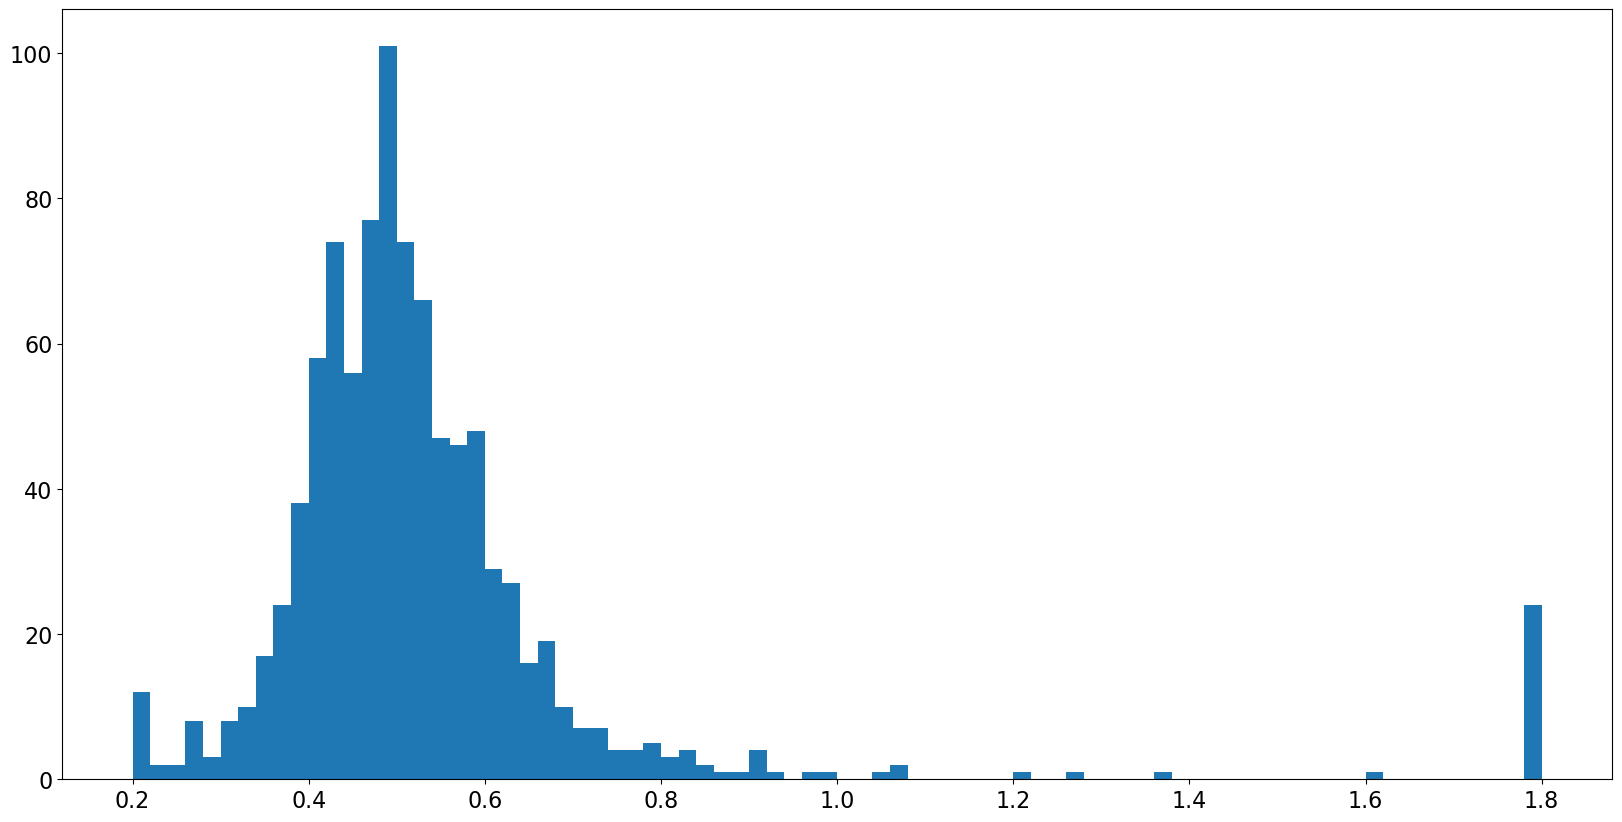

In [37]:
plt.figure(figsize=(20, 10))
plt.hist(ks.values(), bins=80)

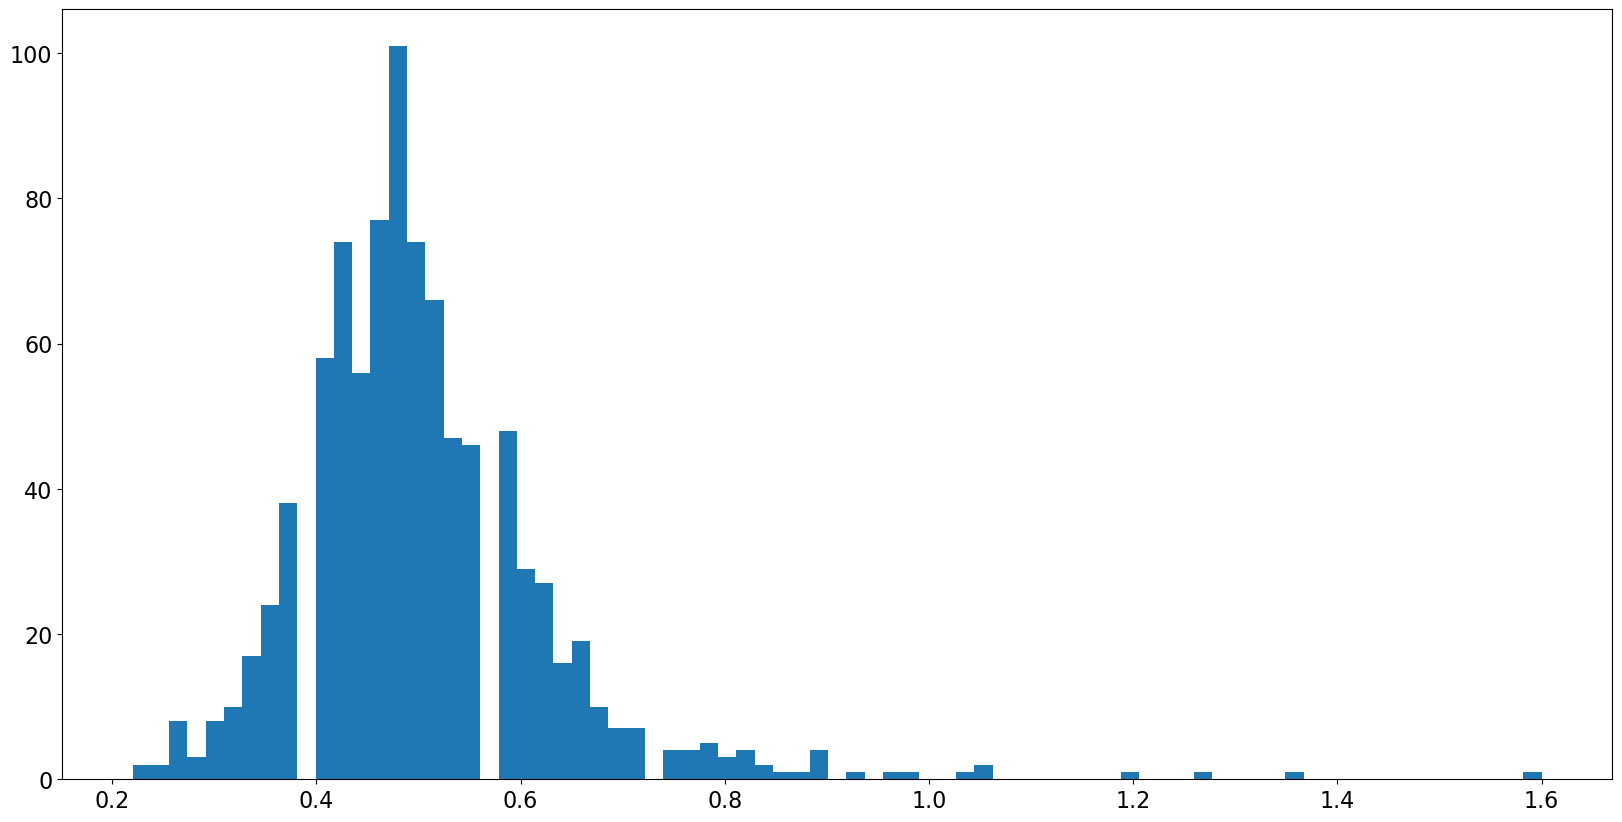

In [38]:
plt.figure(figsize=(20, 10))
counts, bins, _ = plt.hist([ x for x in ks.values() if x > 0.201 and x < 1.799 ], bins=77)

In [39]:
counts, bins

(array([  2.,   2.,   8.,   3.,   8.,  10.,  17.,  24.,  38.,   0.,  58.,
         74.,  56.,  77., 101.,  74.,  66.,  47.,  46.,   0.,  48.,  29.,
         27.,  16.,  19.,  10.,   7.,   7.,   0.,   4.,   4.,   5.,   3.,
          4.,   2.,   1.,   1.,   4.,   0.,   1.,   0.,   1.,   1.,   0.,
          0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.22      , 0.23792208, 0.25584416, 0.27376623, 0.29168831,
        0.30961039, 0.32753247, 0.34545455, 0.36337662, 0.3812987 ,
        0.39922078, 0.41714286, 0.43506494, 0.45298701, 0.47090909,
        0.48883117, 0.50675325, 0.52467532, 0.5425974 , 0.56051948,
        0.57844156, 0.59636364, 0.61428571, 0.63220779, 0.65012987,
        0.66805195, 0.68597403, 0.7038961 , 0.72181818, 0.73974026,
        0.75766234, 0.77558442, 0.79350649, 0.81142857, 0.82935065,
    

In [40]:
def gaussian(x, *pars):
    A, mu, sigma = pars
    return A * np.exp(-(x-mu)**2/2/sigma**2)

(0.4700333417912453, 0.004543581260014539, -0.07821566613473022)

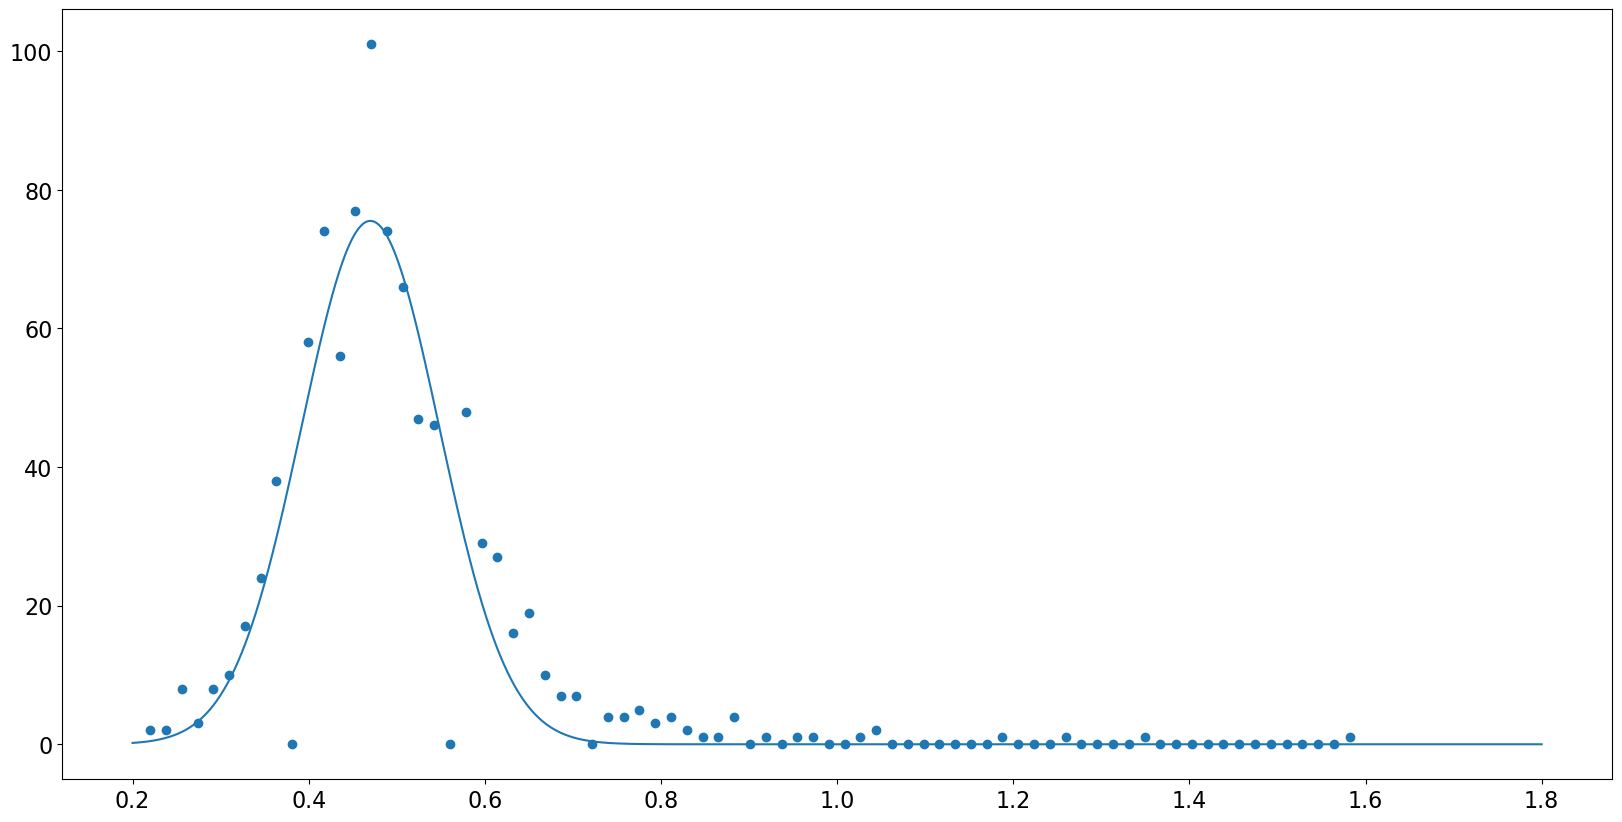

In [41]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=[1, 0, 1])

xs = np.linspace(0.2, 1.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins[:-1], counts)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [42]:
ks_hr = {}
qs_hr = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_hr[gaia_id] = min_k
    qs_hr[gaia_id] = min_q

  0%|                                                                           | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|                                                                 | 1/1000 [00:29<8:19:24, 29.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▏                                                                | 2/1000 [01:04<9:00:43, 32.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▏                                                                | 3/1000 [01:30<8:13:34, 29.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▎                                                                | 4/1000 [01:53<7:26:17, 26.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  0%|▎                                                                | 5/1000 [02:10<6:29:02, 23.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▍                                                                | 6/1000 [02:24<5:32:10, 20.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▍                                                                | 7/1000 [02:45<5:41:01, 20.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▌                                                                | 8/1000 [03:19<6:47:26, 24.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▌                                                                | 9/1000 [03:31<5:44:52, 20.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▋                                                               | 10/1000 [03:54<5:53:58, 21.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▋                                                               | 11/1000 [04:06<5:04:57, 18.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▊                                                               | 12/1000 [04:23<4:59:38, 18.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▊                                                               | 13/1000 [04:41<4:55:50, 17.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  1%|▉                                                               | 14/1000 [04:57<4:44:46, 17.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|▉                                                               | 15/1000 [05:31<6:09:22, 22.50s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█                                                               | 16/1000 [05:49<5:48:12, 21.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█                                                               | 17/1000 [06:08<5:33:52, 20.38s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▏                                                              | 18/1000 [06:30<5:42:04, 20.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▏                                                              | 19/1000 [06:48<5:26:59, 20.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▎                                                              | 20/1000 [07:02<5:00:21, 18.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▎                                                              | 21/1000 [07:24<5:13:41, 19.23s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▍                                                              | 22/1000 [07:44<5:20:32, 19.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▍                                                              | 23/1000 [08:03<5:16:03, 19.41s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▌                                                              | 24/1000 [08:19<4:58:26, 18.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  2%|█▌                                                              | 25/1000 [08:39<5:07:43, 18.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▋                                                              | 26/1000 [08:54<4:45:12, 17.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▋                                                              | 27/1000 [09:12<4:49:24, 17.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▊                                                              | 28/1000 [09:23<4:13:16, 15.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▊                                                              | 29/1000 [09:37<4:07:41, 15.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▉                                                              | 30/1000 [09:54<4:15:00, 15.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|█▉                                                              | 31/1000 [10:29<5:46:39, 21.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██                                                              | 32/1000 [11:03<6:48:16, 25.31s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██                                                              | 33/1000 [11:21<6:11:54, 23.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  3%|██▏                                                             | 34/1000 [11:44<6:10:50, 23.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▏                                                             | 35/1000 [11:59<5:33:59, 20.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▎                                                             | 36/1000 [12:13<5:01:34, 18.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▎                                                             | 37/1000 [12:27<4:36:42, 17.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▍                                                             | 38/1000 [12:50<5:03:38, 18.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▍                                                             | 39/1000 [13:10<5:11:02, 19.42s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▌                                                             | 40/1000 [13:31<5:16:18, 19.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▌                                                             | 41/1000 [13:53<5:27:20, 20.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▋                                                             | 42/1000 [14:14<5:27:34, 20.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▊                                                             | 43/1000 [14:34<5:27:57, 20.56s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▊                                                             | 44/1000 [14:57<5:38:10, 21.22s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  4%|██▉                                                             | 45/1000 [15:17<5:30:05, 20.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|██▉                                                             | 46/1000 [15:51<6:34:57, 24.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███                                                             | 47/1000 [16:12<6:14:23, 23.57s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███                                                             | 48/1000 [16:36<6:15:19, 23.65s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▏                                                            | 49/1000 [16:53<5:43:15, 21.66s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▏                                                            | 50/1000 [17:13<5:35:31, 21.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▎                                                            | 51/1000 [17:47<6:38:06, 25.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▎                                                            | 52/1000 [18:01<5:41:30, 21.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▍                                                            | 53/1000 [18:14<5:00:45, 19.06s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  5%|███▍                                                            | 54/1000 [18:31<4:51:20, 18.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▌                                                            | 55/1000 [18:54<5:11:42, 19.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▌                                                            | 56/1000 [19:21<5:47:37, 22.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▋                                                            | 57/1000 [19:43<5:47:58, 22.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▋                                                            | 58/1000 [20:05<5:45:59, 22.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▊                                                            | 59/1000 [20:20<5:12:01, 19.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▊                                                            | 60/1000 [20:38<5:00:36, 19.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▉                                                            | 61/1000 [20:50<4:29:05, 17.19s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|███▉                                                            | 62/1000 [21:04<4:11:30, 16.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████                                                            | 63/1000 [21:19<4:09:37, 15.98s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████                                                            | 64/1000 [21:36<4:14:37, 16.32s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  6%|████▏                                                           | 65/1000 [21:49<3:56:19, 15.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▏                                                           | 66/1000 [22:06<4:03:54, 15.67s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▎                                                           | 67/1000 [22:21<3:59:58, 15.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▎                                                           | 68/1000 [22:55<5:27:31, 21.09s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▍                                                           | 69/1000 [23:09<4:55:32, 19.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▍                                                           | 70/1000 [23:23<4:31:31, 17.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▌                                                           | 71/1000 [23:40<4:28:14, 17.32s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  7%|████▋                                                           | 74/1000 [23:59<2:51:59, 11.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▊                                                           | 75/1000 [24:18<3:18:07, 12.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▊                                                           | 76/1000 [24:50<4:24:08, 17.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▉                                                           | 77/1000 [25:03<4:10:47, 16.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|████▉                                                           | 78/1000 [25:25<4:31:51, 17.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████                                                           | 79/1000 [25:38<4:12:50, 16.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████                                                           | 80/1000 [25:58<4:27:15, 17.43s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▏                                                          | 81/1000 [26:16<4:28:30, 17.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▏                                                          | 82/1000 [26:33<4:28:14, 17.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▎                                                          | 83/1000 [26:46<4:07:38, 16.20s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▍                                                          | 84/1000 [27:00<3:54:26, 15.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  8%|█████▍                                                          | 85/1000 [27:23<4:30:38, 17.75s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▌                                                          | 86/1000 [27:47<4:56:39, 19.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▌                                                          | 87/1000 [28:13<5:27:55, 21.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▋                                                          | 88/1000 [28:31<5:12:11, 20.54s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▋                                                          | 89/1000 [28:52<5:14:10, 20.69s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▊                                                          | 90/1000 [29:12<5:08:39, 20.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▊                                                          | 91/1000 [29:27<4:43:58, 18.74s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▉                                                          | 92/1000 [29:46<4:46:51, 18.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|█████▉                                                          | 93/1000 [29:58<4:11:10, 16.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


  9%|██████                                                          | 94/1000 [30:28<5:14:27, 20.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████                                                          | 95/1000 [31:03<6:16:34, 24.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▏                                                         | 96/1000 [31:28<6:19:06, 25.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▏                                                         | 97/1000 [31:48<5:52:01, 23.39s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                         | 98/1000 [32:07<5:35:03, 22.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                         | 99/1000 [32:27<5:23:18, 21.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                        | 100/1000 [32:40<4:41:41, 18.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▎                                                        | 101/1000 [32:59<4:43:40, 18.93s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▍                                                        | 102/1000 [33:28<5:27:30, 21.88s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▍                                                        | 103/1000 [33:51<5:33:04, 22.28s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▌                                                        | 104/1000 [34:05<4:58:27, 19.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 10%|██████▌                                                        | 105/1000 [34:22<4:43:29, 19.00s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▋                                                        | 106/1000 [34:44<4:57:31, 19.97s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▊                                                        | 108/1000 [35:08<3:59:35, 16.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▊                                                        | 109/1000 [35:24<4:01:53, 16.29s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▉                                                        | 110/1000 [35:37<3:46:01, 15.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|██████▉                                                        | 111/1000 [35:43<3:08:10, 12.70s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████                                                        | 112/1000 [35:58<3:20:33, 13.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████                                                        | 113/1000 [36:16<3:38:27, 14.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 11%|███████▏                                                       | 114/1000 [36:34<3:50:47, 15.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▏                                                       | 115/1000 [36:55<4:13:07, 17.16s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▎                                                       | 116/1000 [37:19<4:42:05, 19.15s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▎                                                       | 117/1000 [37:31<4:11:37, 17.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▍                                                       | 118/1000 [37:46<4:03:19, 16.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▍                                                       | 119/1000 [38:08<4:25:02, 18.05s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▌                                                       | 121/1000 [38:27<3:29:04, 14.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▋                                                       | 122/1000 [38:44<3:38:49, 14.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▋                                                       | 123/1000 [39:02<3:48:12, 15.61s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▊                                                       | 124/1000 [39:37<5:03:12, 20.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 12%|███████▉                                                       | 125/1000 [39:53<4:46:13, 19.63s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|███████▉                                                       | 126/1000 [40:19<5:11:43, 21.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████                                                       | 127/1000 [40:48<5:45:11, 23.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████                                                       | 128/1000 [41:23<6:30:54, 26.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▏                                                      | 129/1000 [41:57<7:02:04, 29.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▏                                                      | 130/1000 [42:11<5:56:30, 24.59s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▎                                                      | 131/1000 [42:29<5:27:50, 22.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▎                                                      | 132/1000 [42:47<5:07:42, 21.27s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▍                                                      | 133/1000 [43:07<5:01:13, 20.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 13%|████████▍                                                      | 134/1000 [43:21<4:32:15, 18.86s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▌                                                      | 135/1000 [43:42<4:40:20, 19.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▌                                                      | 136/1000 [44:02<4:39:18, 19.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▋                                                      | 137/1000 [44:29<5:14:04, 21.84s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▋                                                      | 138/1000 [44:54<5:26:26, 22.72s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▊                                                      | 139/1000 [45:17<5:29:13, 22.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▊                                                      | 140/1000 [45:35<5:04:33, 21.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▉                                                      | 141/1000 [45:43<4:09:54, 17.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|████████▉                                                      | 142/1000 [45:56<3:49:52, 16.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████                                                      | 143/1000 [46:15<4:03:22, 17.04s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████                                                      | 144/1000 [46:37<4:21:06, 18.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 14%|█████████▏                                                     | 145/1000 [46:59<4:38:07, 19.52s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▏                                                     | 146/1000 [47:22<4:51:22, 20.47s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▎                                                     | 147/1000 [47:40<4:41:37, 19.81s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▎                                                     | 148/1000 [47:55<4:21:56, 18.45s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▍                                                     | 149/1000 [48:03<3:34:47, 15.14s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▍                                                     | 150/1000 [48:12<3:09:47, 13.40s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▌                                                     | 152/1000 [48:51<3:48:42, 16.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▋                                                     | 153/1000 [49:07<3:49:23, 16.25s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 15%|█████████▋                                                     | 154/1000 [49:19<3:31:51, 15.03s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▊                                                     | 155/1000 [49:32<3:24:56, 14.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▊                                                     | 156/1000 [49:34<2:35:48, 11.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▉                                                     | 157/1000 [49:57<3:22:17, 14.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|█████████▉                                                     | 158/1000 [50:16<3:41:08, 15.76s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████                                                     | 160/1000 [50:32<2:52:54, 12.35s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▏                                                    | 161/1000 [50:54<3:22:50, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▏                                                    | 162/1000 [51:17<3:55:50, 16.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▎                                                    | 163/1000 [51:31<3:43:04, 15.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▎                                                    | 164/1000 [51:50<3:54:24, 16.82s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 16%|██████████▍                                                    | 165/1000 [52:21<4:49:00, 20.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▍                                                    | 166/1000 [52:54<5:38:34, 24.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▌                                                    | 167/1000 [53:12<5:11:45, 22.46s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▌                                                    | 168/1000 [53:29<4:50:25, 20.94s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▋                                                    | 169/1000 [53:39<4:04:54, 17.68s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▋                                                    | 170/1000 [53:53<3:48:25, 16.51s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▊                                                    | 171/1000 [54:12<3:59:28, 17.33s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▊                                                    | 172/1000 [54:28<3:54:25, 16.99s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▉                                                    | 173/1000 [54:40<3:33:30, 15.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 17%|██████████▉                                                    | 174/1000 [54:42<2:38:09, 11.49s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████                                                    | 175/1000 [54:56<2:46:05, 12.08s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████                                                    | 176/1000 [55:19<3:34:11, 15.60s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▏                                                   | 177/1000 [55:39<3:51:57, 16.91s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▏                                                   | 178/1000 [56:03<4:17:18, 18.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▎                                                   | 179/1000 [56:35<5:11:03, 22.73s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▎                                                   | 180/1000 [56:55<4:59:21, 21.90s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▍                                                   | 181/1000 [57:29<5:49:58, 25.64s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▍                                                   | 182/1000 [57:46<5:15:15, 23.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▌                                                   | 183/1000 [58:08<5:11:09, 22.85s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▌                                                   | 184/1000 [58:29<5:00:32, 22.10s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 18%|███████████▋                                                   | 185/1000 [58:54<5:14:04, 23.12s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▋                                                   | 186/1000 [59:22<5:30:51, 24.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▊                                                   | 188/1000 [59:39<3:52:21, 17.17s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▌                                                 | 189/1000 [1:00:14<4:50:18, 21.48s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▌                                                 | 190/1000 [1:00:29<4:30:06, 20.01s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▋                                                 | 191/1000 [1:00:49<4:28:07, 19.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▋                                                 | 192/1000 [1:01:00<3:56:04, 17.53s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▊                                                 | 193/1000 [1:01:19<3:59:20, 17.79s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 19%|███████████▊                                                 | 194/1000 [1:01:47<4:39:51, 20.83s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|███████████▉                                                 | 195/1000 [1:02:12<4:55:51, 22.05s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|███████████▉                                                 | 196/1000 [1:02:37<5:07:48, 22.97s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████                                                 | 197/1000 [1:02:53<4:39:32, 20.89s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████                                                 | 198/1000 [1:03:14<4:37:46, 20.78s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▏                                                | 199/1000 [1:03:26<4:03:49, 18.26s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▏                                                | 200/1000 [1:03:41<3:51:14, 17.34s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▎                                                | 201/1000 [1:03:54<3:30:27, 15.80s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▎                                                | 202/1000 [1:04:18<4:04:09, 18.36s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▍                                                | 203/1000 [1:04:50<4:59:31, 22.55s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▍                                                | 204/1000 [1:05:05<4:28:29, 20.24s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 20%|████████████▌                                                | 205/1000 [1:05:17<3:53:29, 17.62s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▌                                                | 206/1000 [1:05:44<4:32:25, 20.59s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▋                                                | 208/1000 [1:06:11<3:49:36, 17.40s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▋                                                | 209/1000 [1:06:28<3:46:27, 17.18s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▊                                                | 210/1000 [1:06:40<3:30:04, 15.96s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▊                                                | 211/1000 [1:07:04<3:57:39, 18.07s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▉                                                | 212/1000 [1:07:25<4:08:54, 18.95s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|████████████▉                                                | 213/1000 [1:07:39<3:46:53, 17.30s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████                                                | 214/1000 [1:08:04<4:18:57, 19.77s/it]

calibrating gaia...



Processing data:   0%|                                                           | 0/1 [00:00<?, ?spec/s]
                                                                                                         

done.


 21%|█████████████                                                | 214/1000 [1:08:16<4:10:45, 19.14s/it]


KeyboardInterrupt: 

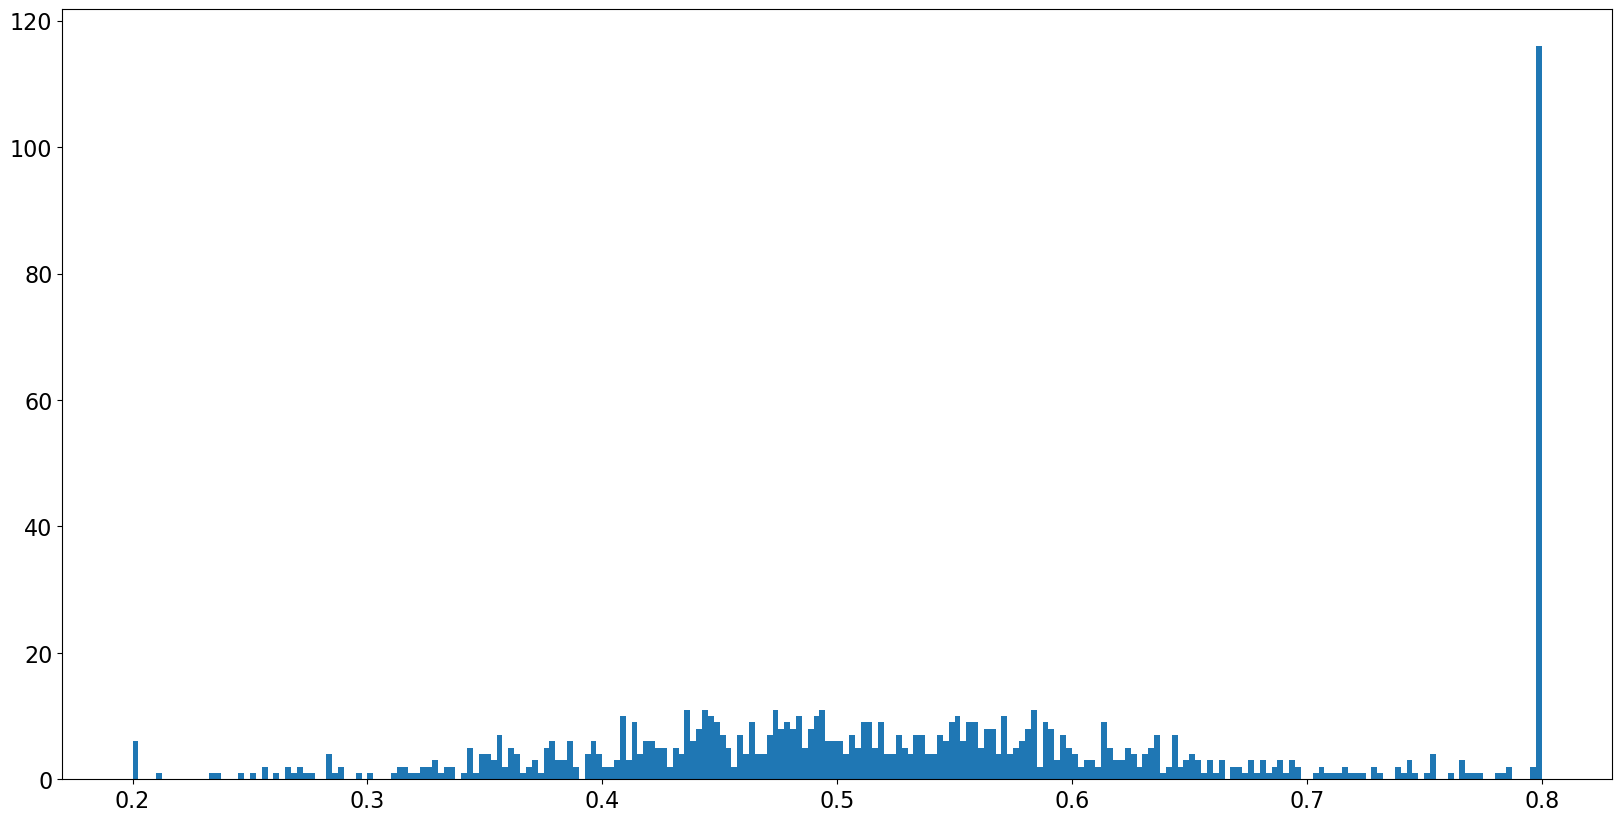

In [14]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist(ks_hr.values(), bins=240)

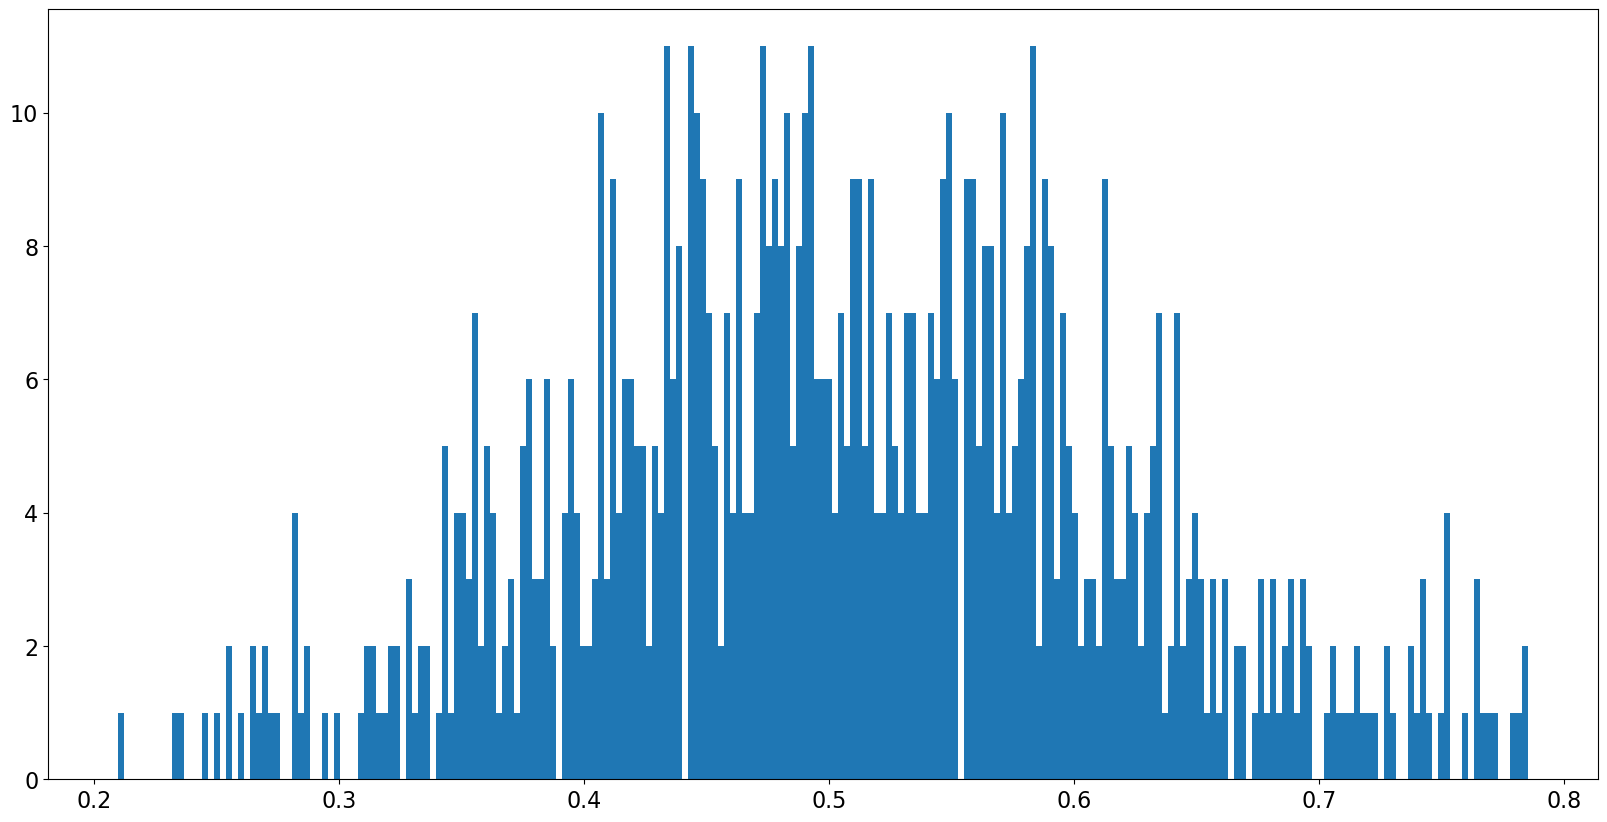

In [15]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist([ x for x in ks_hr.values() if x > 0.20251 and x < 0.795 ], bins=235)

(0.5038633168165113, 0.004680107117480441, 0.10911001953910596)

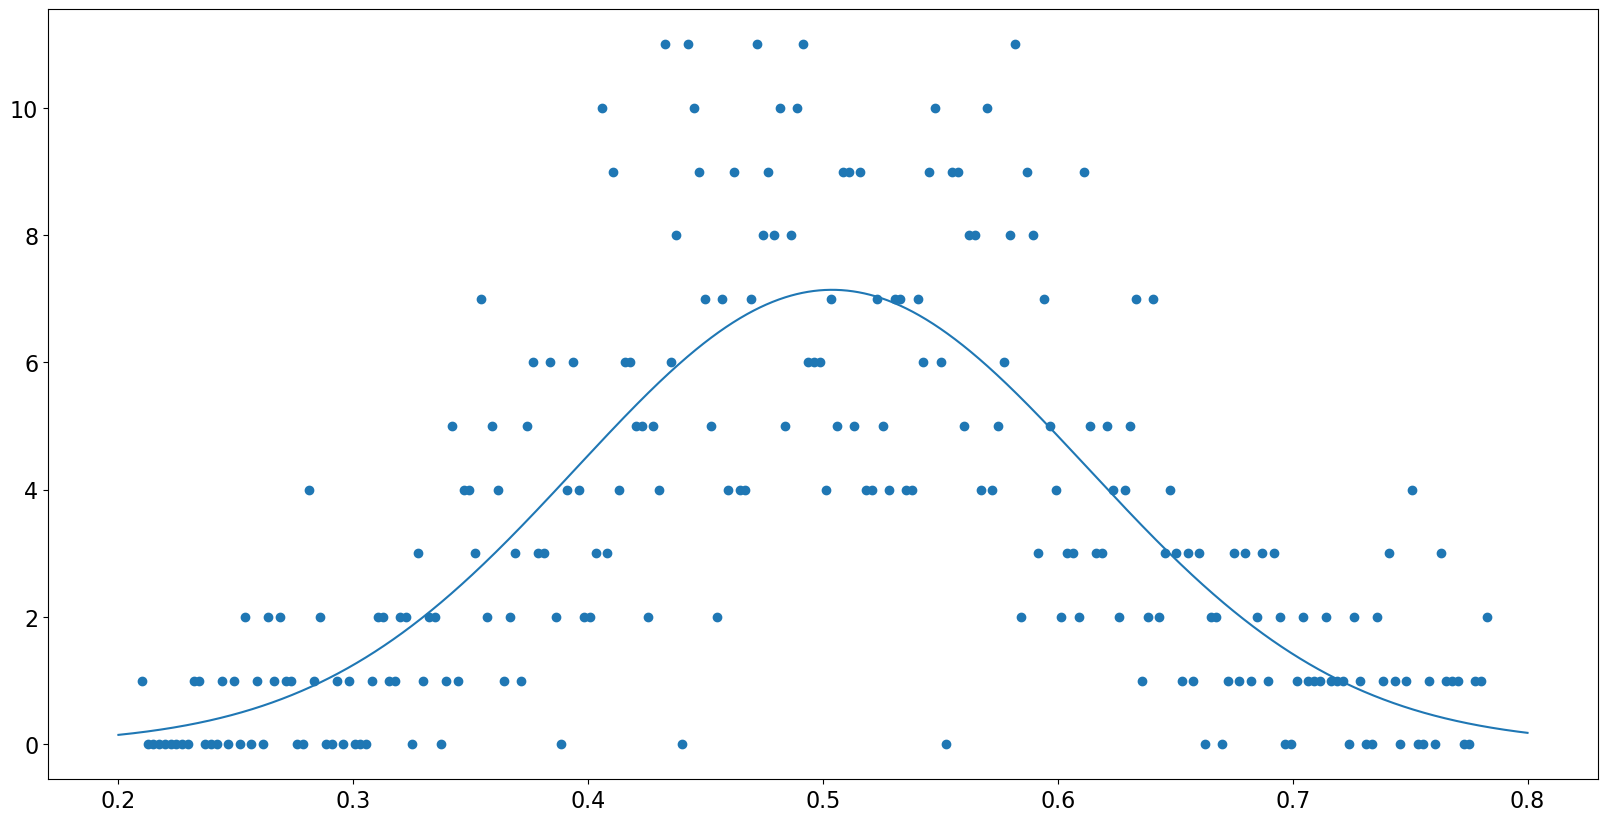

In [18]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins2[:-1], counts2, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins2[:-1], counts2)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [14]:
ks_adj = {}
qs_adj = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
    else:
        gaia_flux *= qs_hr[gaia_id]
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_adj[gaia_id] = min_k
    qs_adj[gaia_id] = min_q

  0%|                                                                                                                                | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|                                                                                                                    | 1/1000 [01:57<32:43:09, 117.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▏                                                                                                                    | 2/1000 [02:59<23:32:41, 84.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▎                                                                                                                    | 3/1000 [03:40<17:59:28, 64.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▍                                                                                                                    | 4/1000 [05:19<21:40:53, 78.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▌                                                                                                                    | 5/1000 [06:35<21:20:43, 77.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▋                                                                                                                    | 6/1000 [07:36<19:49:31, 71.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▊                                                                                                                    | 7/1000 [09:12<22:02:24, 79.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▉                                                                                                                    | 8/1000 [10:15<20:29:26, 74.36s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▎                                                                                                                  | 11/1000 [13:11<17:56:34, 65.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▍                                                                                                                  | 12/1000 [13:31<15:15:03, 55.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 13/1000 [14:26<15:10:43, 55.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 14/1000 [15:42<16:38:02, 60.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▋                                                                                                                  | 15/1000 [18:38<24:55:12, 91.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▊                                                                                                                  | 16/1000 [18:50<18:56:20, 69.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██                                                                                                                  | 18/1000 [18:56<10:57:50, 40.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▏                                                                                                                 | 19/1000 [20:38<15:00:01, 55.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▎                                                                                                                 | 20/1000 [22:03<17:03:41, 62.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▍                                                                                                                 | 21/1000 [24:59<25:15:35, 92.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▌                                                                                                                 | 22/1000 [25:43<21:36:00, 79.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▋                                                                                                                | 23/1000 [28:59<30:27:49, 112.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▊                                                                                                                | 24/1000 [30:15<27:38:29, 101.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▉                                                                                                                 | 25/1000 [31:02<23:13:50, 85.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███                                                                                                                 | 26/1000 [32:42<24:21:09, 90.01s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▍                                                                                                                | 30/1000 [34:14<12:56:08, 48.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▋                                                                                                                | 32/1000 [35:18<11:34:47, 43.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▊                                                                                                                | 33/1000 [35:51<11:05:20, 41.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▉                                                                                                                | 34/1000 [36:59<12:33:26, 46.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████                                                                                                                | 35/1000 [38:16<14:21:40, 53.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▏                                                                                                               | 36/1000 [41:28<23:25:28, 87.48s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▍                                                                                                               | 38/1000 [43:10<19:20:26, 72.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▌                                                                                                               | 39/1000 [44:25<19:29:38, 73.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▌                                                                                                              | 40/1000 [47:41<27:30:58, 103.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▋                                                                                                              | 41/1000 [49:18<27:04:33, 101.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▊                                                                                                              | 42/1000 [51:20<28:30:49, 107.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▉                                                                                                               | 43/1000 [52:38<26:18:34, 98.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████                                                                                                               | 44/1000 [54:03<25:13:17, 94.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████▏                                                                                                             | 45/1000 [56:17<28:09:44, 106.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▎                                                                                                             | 46/1000 [57:42<26:32:03, 100.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▍                                                                                                              | 47/1000 [58:54<24:19:59, 91.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▌                                                                                                            | 49/1000 [1:00:25<18:40:24, 70.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▋                                                                                                            | 50/1000 [1:01:10<16:57:41, 64.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▊                                                                                                            | 51/1000 [1:03:13<20:58:59, 79.60s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████                                                                                                            | 53/1000 [1:04:35<16:35:37, 63.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████▏                                                                                                           | 54/1000 [1:05:41<16:44:46, 63.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▎                                                                                                           | 55/1000 [1:06:27<15:37:05, 59.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 56/1000 [1:08:45<20:59:50, 80.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 57/1000 [1:10:14<21:35:14, 82.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▌                                                                                                          | 58/1000 [1:13:08<28:17:50, 108.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▋                                                                                                           | 59/1000 [1:14:03<24:16:04, 92.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▊                                                                                                           | 60/1000 [1:15:36<24:18:36, 93.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▉                                                                                                           | 61/1000 [1:16:16<20:11:22, 77.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████                                                                                                           | 62/1000 [1:17:48<21:19:04, 81.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▏                                                                                                          | 63/1000 [1:19:52<24:33:56, 94.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▎                                                                                                          | 64/1000 [1:20:46<21:25:13, 82.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▍                                                                                                          | 65/1000 [1:22:42<23:58:35, 92.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▌                                                                                                          | 66/1000 [1:24:21<24:27:38, 94.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▋                                                                                                          | 67/1000 [1:25:17<21:30:04, 82.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▊                                                                                                          | 69/1000 [1:27:08<18:09:18, 70.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▉                                                                                                          | 70/1000 [1:28:16<17:58:48, 69.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████                                                                                                          | 71/1000 [1:29:44<19:12:36, 74.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▏                                                                                                         | 72/1000 [1:31:32<21:33:30, 83.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▎                                                                                                         | 73/1000 [1:33:38<24:34:35, 95.44s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▌                                                                                                         | 75/1000 [1:35:45<20:53:56, 81.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▋                                                                                                         | 76/1000 [1:37:02<20:34:58, 80.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▊                                                                                                         | 77/1000 [1:38:58<22:53:53, 89.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▊                                                                                                        | 78/1000 [1:41:12<25:56:39, 101.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 79/1000 [1:42:48<25:33:09, 99.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 80/1000 [1:43:32<21:29:21, 84.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▏                                                                                                        | 81/1000 [1:44:36<19:59:47, 78.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▎                                                                                                        | 82/1000 [1:46:27<22:22:58, 87.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▍                                                                                                        | 83/1000 [1:47:56<22:27:39, 88.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▌                                                                                                        | 84/1000 [1:49:42<23:47:41, 93.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▋                                                                                                        | 85/1000 [1:51:12<23:29:47, 92.45s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|█████████▉                                                                                                        | 87/1000 [1:53:11<19:35:22, 77.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████                                                                                                        | 88/1000 [1:54:14<18:40:45, 73.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▏                                                                                                       | 89/1000 [1:55:24<18:26:49, 72.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 90/1000 [1:56:50<19:15:45, 76.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 91/1000 [1:58:57<22:51:58, 90.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▍                                                                                                       | 92/1000 [2:00:23<22:29:08, 89.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▌                                                                                                      | 93/1000 [2:02:50<26:41:17, 105.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▋                                                                                                       | 94/1000 [2:03:58<23:53:17, 94.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▋                                                                                                      | 95/1000 [2:06:03<26:04:15, 103.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▉                                                                                                       | 96/1000 [2:07:07<23:07:10, 92.07s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▏                                                                                                      | 98/1000 [2:09:05<19:16:09, 76.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                      | 99/1000 [2:10:59<21:32:48, 86.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                     | 100/1000 [2:12:27<21:38:25, 86.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                    | 101/1000 [2:15:09<26:41:57, 106.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▌                                                                                                     | 102/1000 [2:16:26<24:34:53, 98.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▌                                                                                                    | 103/1000 [2:18:27<26:07:35, 104.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▋                                                                                                    | 104/1000 [2:20:50<28:51:07, 115.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|███████████▉                                                                                                     | 106/1000 [2:22:43<22:06:55, 89.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████                                                                                                     | 107/1000 [2:24:38<23:40:21, 95.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▏                                                                                                    | 108/1000 [2:26:06<23:12:05, 93.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▎                                                                                                    | 109/1000 [2:27:27<22:19:47, 90.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▍                                                                                                    | 110/1000 [2:27:34<16:32:56, 66.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▌                                                                                                    | 111/1000 [2:28:44<16:45:42, 67.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▋                                                                                                    | 112/1000 [2:30:21<18:47:57, 76.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▋                                                                                                   | 113/1000 [2:33:17<25:58:08, 105.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▊                                                                                                   | 114/1000 [2:36:13<31:01:50, 126.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                   | 115/1000 [2:38:20<31:04:24, 126.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                   | 116/1000 [2:40:34<31:35:11, 128.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████                                                                                                   | 117/1000 [2:41:39<26:53:42, 109.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▏                                                                                                  | 118/1000 [2:42:59<24:42:37, 100.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▎                                                                                                  | 119/1000 [2:45:25<27:59:52, 114.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▍                                                                                                  | 120/1000 [2:46:52<25:55:35, 106.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▋                                                                                                   | 121/1000 [2:47:16<19:54:07, 81.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                   | 122/1000 [2:48:39<19:59:22, 81.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                  | 123/1000 [2:51:33<26:44:37, 109.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▉                                                                                                  | 124/1000 [2:53:12<25:53:05, 106.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|██████████████▏                                                                                                  | 125/1000 [2:54:21<23:06:07, 95.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▏                                                                                                  | 126/1000 [2:56:05<23:47:37, 98.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▏                                                                                                 | 127/1000 [2:58:01<25:02:49, 103.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▎                                                                                                 | 128/1000 [2:59:40<24:40:51, 101.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▍                                                                                                 | 129/1000 [3:02:36<30:02:44, 124.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▌                                                                                                 | 130/1000 [3:04:27<29:03:02, 120.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▋                                                                                                 | 131/1000 [3:06:42<30:07:20, 124.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▊                                                                                                 | 132/1000 [3:07:45<25:34:28, 106.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████                                                                                                  | 133/1000 [3:09:10<24:02:19, 99.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████                                                                                                 | 134/1000 [3:11:16<25:55:46, 107.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████                                                                                                 | 135/1000 [3:12:39<24:07:28, 100.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▏                                                                                                | 136/1000 [3:15:08<27:32:55, 114.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▎                                                                                                | 137/1000 [3:17:26<29:12:49, 121.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▍                                                                                                | 138/1000 [3:20:21<32:58:05, 137.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▌                                                                                                | 139/1000 [3:23:16<35:35:14, 148.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▋                                                                                                | 140/1000 [3:25:04<32:40:14, 136.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▊                                                                                                | 141/1000 [3:26:51<30:28:29, 127.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▉                                                                                                | 142/1000 [3:28:17<27:27:04, 115.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████                                                                                                | 143/1000 [3:29:56<26:15:56, 110.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▎                                                                                                | 144/1000 [3:31:04<23:14:11, 97.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▏                                                                                               | 145/1000 [3:33:24<26:12:31, 110.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▎                                                                                               | 146/1000 [3:36:14<30:26:51, 128.35s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▋                                                                                                | 148/1000 [3:38:16<23:00:37, 97.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                                | 149/1000 [3:39:54<23:00:51, 97.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                               | 150/1000 [3:42:49<27:48:56, 117.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▉                                                                                               | 151/1000 [3:44:49<27:55:15, 118.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▎                                                                                               | 153/1000 [3:46:07<19:40:17, 83.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▍                                                                                               | 154/1000 [3:47:02<18:03:39, 76.86s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 156/1000 [3:48:42<15:27:59, 65.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 157/1000 [3:51:04<19:25:46, 82.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▊                                                                                               | 158/1000 [3:52:17<18:49:33, 80.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▉                                                                                               | 159/1000 [3:53:21<17:50:34, 76.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████                                                                                               | 160/1000 [3:54:46<18:19:55, 78.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▏                                                                                              | 161/1000 [3:56:06<18:23:59, 78.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▎                                                                                              | 162/1000 [3:57:21<18:08:27, 77.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▍                                                                                              | 163/1000 [3:58:52<18:59:40, 81.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▌                                                                                              | 164/1000 [4:00:01<18:04:58, 77.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▋                                                                                              | 165/1000 [4:01:40<19:32:14, 84.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                              | 166/1000 [4:02:58<19:04:31, 82.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▋                                                                                             | 167/1000 [4:05:51<25:17:58, 109.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                             | 168/1000 [4:07:34<24:47:37, 107.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▉                                                                                             | 169/1000 [4:09:35<25:44:58, 111.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████                                                                                             | 170/1000 [4:11:38<26:28:51, 114.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▏                                                                                            | 171/1000 [4:13:03<24:22:47, 105.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▎                                                                                            | 172/1000 [4:15:05<25:27:17, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▍                                                                                            | 173/1000 [4:16:25<23:22:33, 101.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▋                                                                                             | 174/1000 [4:17:50<22:11:24, 96.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▊                                                                                             | 175/1000 [4:19:27<22:11:02, 96.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▉                                                                                             | 176/1000 [4:21:00<21:50:46, 95.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▊                                                                                            | 177/1000 [4:22:57<23:20:57, 102.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                             | 178/1000 [4:24:11<21:21:50, 93.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                            | 179/1000 [4:27:26<28:14:57, 123.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▏                                                                                           | 180/1000 [4:30:20<31:41:32, 139.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▎                                                                                           | 181/1000 [4:33:11<33:47:28, 148.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▍                                                                                           | 182/1000 [4:35:32<33:16:28, 146.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▍                                                                                           | 183/1000 [4:36:40<27:54:02, 122.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▌                                                                                           | 184/1000 [4:38:10<25:35:13, 112.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▋                                                                                           | 185/1000 [4:40:02<25:29:56, 112.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▊                                                                                           | 186/1000 [4:41:58<25:41:18, 113.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▉                                                                                           | 187/1000 [4:43:36<24:38:17, 109.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████                                                                                           | 188/1000 [4:45:11<23:38:11, 104.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▏                                                                                          | 189/1000 [4:46:43<22:44:17, 100.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▍                                                                                           | 190/1000 [4:48:13<21:59:28, 97.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▌                                                                                           | 191/1000 [4:49:50<21:53:59, 97.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                           | 192/1000 [4:50:43<18:53:04, 84.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▊                                                                                           | 193/1000 [4:52:02<18:31:38, 82.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                          | 194/1000 [4:54:56<24:35:11, 109.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████                                                                                           | 195/1000 [4:56:09<22:05:46, 98.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▏                                                                                          | 196/1000 [4:57:40<21:31:51, 96.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 197/1000 [4:58:15<17:24:54, 78.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 198/1000 [5:00:18<20:25:22, 91.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                         | 199/1000 [5:02:25<22:44:44, 102.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▌                                                                                          | 200/1000 [5:03:43<21:07:28, 95.06s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                          | 202/1000 [5:06:55<21:08:42, 95.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▉                                                                                          | 203/1000 [5:07:59<19:24:46, 87.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                         | 204/1000 [5:11:12<25:27:34, 115.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▉                                                                                         | 205/1000 [5:12:20<22:37:16, 102.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▎                                                                                         | 206/1000 [5:13:52<21:57:10, 99.54s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 208/1000 [5:15:37<17:15:36, 78.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 209/1000 [5:16:59<17:27:54, 79.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▋                                                                                         | 210/1000 [5:18:21<17:33:05, 79.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▊                                                                                         | 211/1000 [5:19:05<15:24:19, 70.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▉                                                                                         | 212/1000 [5:20:56<17:52:28, 81.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▊                                                                                        | 213/1000 [5:23:51<23:37:46, 108.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▉                                                                                        | 214/1000 [5:25:48<24:09:16, 110.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▎                                                                                        | 215/1000 [5:26:44<20:40:35, 94.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▍                                                                                        | 216/1000 [5:28:12<20:11:18, 92.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▌                                                                                        | 217/1000 [5:29:47<20:18:19, 93.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 218/1000 [5:31:32<21:04:11, 97.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 219/1000 [5:32:38<18:59:24, 87.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                        | 220/1000 [5:33:43<17:33:30, 81.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                       | 221/1000 [5:36:11<21:50:54, 100.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                       | 222/1000 [5:38:04<22:36:59, 104.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                       | 223/1000 [5:39:25<21:03:12, 97.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▎                                                                                       | 224/1000 [5:40:51<20:14:47, 93.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                      | 225/1000 [5:43:45<25:23:44, 117.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▌                                                                                       | 226/1000 [5:44:37<21:08:37, 98.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▋                                                                                       | 227/1000 [5:45:36<18:31:54, 86.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▊                                                                                       | 228/1000 [5:46:52<17:52:16, 83.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 229/1000 [5:48:38<19:18:10, 90.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 230/1000 [5:50:29<20:37:55, 96.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████                                                                                       | 231/1000 [5:51:02<16:30:44, 77.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▏                                                                                      | 232/1000 [5:53:16<20:09:40, 94.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████                                                                                      | 233/1000 [5:55:23<22:11:53, 104.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▏                                                                                     | 234/1000 [5:57:24<23:11:42, 109.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▎                                                                                     | 235/1000 [5:59:26<24:01:51, 113.09s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▊                                                                                      | 237/1000 [6:00:57<17:21:31, 81.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▉                                                                                      | 238/1000 [6:02:34<18:06:36, 85.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████                                                                                      | 239/1000 [6:03:38<16:55:54, 80.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▉                                                                                     | 240/1000 [6:06:20<21:34:07, 102.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▏                                                                                     | 241/1000 [6:07:39<20:10:24, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▎                                                                                     | 242/1000 [6:08:42<18:12:31, 86.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                     | 243/1000 [6:09:43<16:38:20, 79.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▌                                                                                     | 244/1000 [6:11:32<18:24:27, 87.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                    | 245/1000 [6:14:46<25:00:38, 119.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▌                                                                                    | 246/1000 [6:16:12<22:51:51, 109.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▋                                                                                    | 247/1000 [6:18:02<22:55:28, 109.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                     | 248/1000 [6:19:16<20:40:22, 98.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▉                                                                                    | 249/1000 [6:21:48<23:58:11, 114.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                    | 250/1000 [6:23:31<23:08:39, 111.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                    | 251/1000 [6:25:22<23:06:57, 111.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▏                                                                                   | 252/1000 [6:26:40<21:01:51, 101.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▌                                                                                    | 253/1000 [6:27:24<17:25:51, 84.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▍                                                                                   | 254/1000 [6:30:21<23:13:41, 112.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▌                                                                                   | 255/1000 [6:31:52<21:50:34, 105.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▋                                                                                   | 256/1000 [6:34:03<23:25:54, 113.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                    | 257/1000 [6:35:02<20:00:56, 96.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▉                                                                                   | 258/1000 [6:37:00<21:18:06, 103.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 259/1000 [6:39:55<25:41:25, 124.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 260/1000 [6:41:53<25:15:06, 122.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▏                                                                                  | 261/1000 [6:42:59<21:40:35, 105.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▎                                                                                  | 262/1000 [6:44:37<21:11:40, 103.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▍                                                                                  | 263/1000 [6:46:13<20:41:57, 101.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▊                                                                                   | 264/1000 [6:47:20<18:37:35, 91.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▉                                                                                   | 265/1000 [6:48:11<16:07:53, 79.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████                                                                                   | 266/1000 [6:49:21<15:34:00, 76.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                  | 267/1000 [6:50:49<16:15:26, 79.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▎                                                                                  | 268/1000 [6:52:18<16:46:30, 82.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                 | 269/1000 [6:55:01<21:38:35, 106.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                 | 270/1000 [6:56:42<21:15:38, 104.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▎                                                                                 | 271/1000 [6:58:21<20:52:14, 103.07s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▊                                                                                  | 273/1000 [6:59:44<15:05:45, 74.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▉                                                                                  | 274/1000 [7:02:32<19:45:29, 97.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████                                                                                  | 275/1000 [7:04:18<20:07:36, 99.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▏                                                                                 | 276/1000 [7:05:54<19:52:00, 98.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▎                                                                                 | 277/1000 [7:07:18<19:00:51, 94.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▍                                                                                 | 278/1000 [7:08:45<18:33:43, 92.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▌                                                                                 | 279/1000 [7:10:30<19:16:17, 96.22s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 281/1000 [7:13:26<18:28:19, 92.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 282/1000 [7:15:20<19:30:36, 97.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▉                                                                                 | 283/1000 [7:16:18<17:25:22, 87.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████                                                                                 | 284/1000 [7:18:11<18:44:57, 94.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████▏                                                                                | 285/1000 [7:20:00<19:33:11, 98.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▎                                                                                | 286/1000 [7:20:51<16:50:20, 84.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▍                                                                                | 287/1000 [7:21:38<14:38:28, 73.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▌                                                                                | 288/1000 [7:23:20<16:14:51, 82.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▋                                                                                | 289/1000 [7:25:02<17:22:26, 87.97s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 291/1000 [7:27:11<15:12:17, 77.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 292/1000 [7:28:20<14:48:14, 75.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████                                                                                | 293/1000 [7:29:25<14:15:55, 72.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████▏                                                                               | 294/1000 [7:31:19<16:25:21, 83.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▎                                                                               | 295/1000 [7:32:14<14:48:35, 75.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▍                                                                               | 296/1000 [7:33:34<15:02:08, 76.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▌                                                                               | 297/1000 [7:35:02<15:41:17, 80.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▋                                                                               | 298/1000 [7:36:29<16:00:04, 82.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▊                                                                               | 299/1000 [7:38:44<19:01:52, 97.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▉                                                                               | 300/1000 [7:39:31<16:03:32, 82.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████                                                                               | 301/1000 [7:41:18<17:28:26, 89.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▏                                                                              | 302/1000 [7:42:37<16:49:10, 86.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▉                                                                              | 303/1000 [7:44:59<19:58:32, 103.17s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▍                                                                              | 305/1000 [7:46:10<13:53:20, 71.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▌                                                                              | 306/1000 [7:47:46<15:03:45, 78.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                              | 307/1000 [7:50:06<18:07:37, 94.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▊                                                                              | 308/1000 [7:51:38<17:59:50, 93.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▌                                                                             | 309/1000 [7:54:02<20:41:05, 107.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                             | 310/1000 [7:56:05<21:28:48, 112.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▊                                                                             | 311/1000 [7:57:34<20:09:33, 105.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▉                                                                             | 312/1000 [7:59:35<20:59:24, 109.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▎                                                                             | 313/1000 [8:00:45<18:45:36, 98.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▏                                                                            | 314/1000 [8:03:57<24:00:38, 126.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▎                                                                            | 315/1000 [8:07:16<28:07:16, 147.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▍                                                                            | 316/1000 [8:08:59<25:29:42, 134.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▌                                                                            | 317/1000 [8:10:52<24:17:18, 128.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▉                                                                             | 318/1000 [8:11:01<17:30:24, 92.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                            | 320/1000 [8:13:13<15:08:25, 80.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▎                                                                            | 321/1000 [8:14:24<14:43:12, 78.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████                                                                            | 322/1000 [8:17:21<19:33:53, 103.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                           | 323/1000 [8:19:07<19:37:28, 104.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▌                                                                            | 324/1000 [8:20:16<17:42:52, 94.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▋                                                                            | 325/1000 [8:21:04<15:13:13, 81.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▊                                                                            | 326/1000 [8:22:50<16:32:40, 88.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▉                                                                            | 327/1000 [8:23:47<14:48:04, 79.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████                                                                            | 328/1000 [8:25:27<15:56:47, 85.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▏                                                                           | 329/1000 [8:27:07<16:44:43, 89.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▎                                                                           | 330/1000 [8:28:09<15:09:36, 81.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▍                                                                           | 331/1000 [8:30:01<16:49:08, 90.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▌                                                                           | 332/1000 [8:31:39<17:13:22, 92.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 333/1000 [8:33:08<16:58:00, 91.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 334/1000 [8:34:42<17:03:49, 92.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                           | 335/1000 [8:36:18<17:17:18, 93.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                           | 336/1000 [8:37:24<15:43:20, 85.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████                                                                           | 337/1000 [8:39:16<17:10:40, 93.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                          | 338/1000 [8:41:37<19:46:40, 107.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                          | 339/1000 [8:43:22<19:35:31, 106.70s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▌                                                                          | 341/1000 [8:44:18<12:54:55, 70.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▋                                                                          | 342/1000 [8:44:27<10:06:30, 55.30s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|███████████████████████████████████████▏                                                                          | 344/1000 [8:45:41<8:41:17, 47.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▉                                                                          | 345/1000 [8:47:44<11:48:14, 64.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████                                                                          | 346/1000 [8:50:35<16:32:02, 91.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▏                                                                         | 347/1000 [8:52:04<16:24:40, 90.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|██████████████████████████████████████▉                                                                         | 348/1000 [8:54:57<20:24:00, 112.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████                                                                         | 349/1000 [8:56:33<19:34:07, 108.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▏                                                                        | 350/1000 [8:58:17<19:19:08, 107.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▋                                                                         | 351/1000 [8:59:38<17:55:35, 99.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▍                                                                        | 352/1000 [9:02:08<20:32:48, 114.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▉                                                                         | 353/1000 [9:02:56<16:59:36, 94.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|████████████████████████████████████████                                                                         | 354/1000 [9:04:37<17:18:51, 96.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|███████████████████████████████████████▊                                                                        | 355/1000 [9:06:47<19:07:01, 106.70s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▍                                                                        | 358/1000 [9:08:39<12:03:56, 67.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▌                                                                        | 359/1000 [9:10:23<13:24:55, 75.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▋                                                                        | 360/1000 [9:11:45<13:41:53, 77.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▊                                                                        | 361/1000 [9:13:25<14:39:50, 82.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▉                                                                        | 362/1000 [9:15:02<15:19:46, 86.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████                                                                        | 363/1000 [9:16:42<15:56:51, 90.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 364/1000 [9:18:09<15:45:04, 89.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 365/1000 [9:19:10<14:19:50, 81.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|████████████████████████████████████████▉                                                                       | 366/1000 [9:22:03<18:58:05, 107.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████                                                                       | 367/1000 [9:24:20<20:26:23, 116.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▏                                                                      | 368/1000 [9:27:30<24:14:18, 138.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▎                                                                      | 369/1000 [9:29:36<23:33:19, 134.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▍                                                                      | 370/1000 [9:31:39<22:57:47, 131.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▌                                                                      | 371/1000 [9:34:27<24:49:50, 142.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▋                                                                      | 372/1000 [9:35:45<21:26:32, 122.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▊                                                                      | 373/1000 [9:36:57<18:44:31, 107.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|██████████████████████████████████████████▎                                                                      | 374/1000 [9:37:42<15:29:08, 89.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 375/1000 [9:39:01<14:56:23, 86.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 376/1000 [9:40:07<13:50:13, 79.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▏                                                                     | 377/1000 [9:43:18<19:36:13, 113.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▎                                                                     | 378/1000 [9:44:38<17:52:14, 103.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                      | 379/1000 [9:46:01<16:44:43, 97.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▌                                                                     | 380/1000 [9:47:49<17:16:32, 100.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▋                                                                     | 381/1000 [9:49:34<17:30:20, 101.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                     | 382/1000 [9:52:18<20:41:05, 120.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▉                                                                     | 383/1000 [9:53:51<19:13:53, 112.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 384/1000 [9:55:30<18:32:51, 108.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 385/1000 [9:57:20<18:34:26, 108.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▏                                                                    | 386/1000 [9:59:17<18:58:14, 111.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|██████████████████████████████████████████▉                                                                    | 387/1000 [10:00:37<17:20:19, 101.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████                                                                    | 388/1000 [10:02:39<18:21:11, 107.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▋                                                                    | 390/1000 [10:04:49<14:56:03, 88.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▊                                                                    | 391/1000 [10:06:05<14:23:19, 85.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▌                                                                   | 392/1000 [10:08:51<17:57:04, 106.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▌                                                                   | 393/1000 [10:10:35<17:48:10, 105.59s/it]

calibrating gaia...
[Errno 104] Connection reset by peer
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████▏                                                                   | 394/1000 [10:11:49<16:19:17, 96.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|███████████████████████████████████████████▊                                                                   | 395/1000 [10:14:11<18:26:47, 109.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▎                                                                   | 396/1000 [10:14:54<15:09:21, 90.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▍                                                                   | 397/1000 [10:16:46<16:12:02, 96.72s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                   | 399/1000 [10:18:09<11:56:46, 71.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▊                                                                   | 400/1000 [10:20:05<13:43:14, 82.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▉                                                                   | 401/1000 [10:22:01<15:11:06, 91.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▌                                                                  | 402/1000 [10:24:19<17:15:16, 103.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                  | 403/1000 [10:25:56<16:53:14, 101.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▊                                                                  | 404/1000 [10:28:49<20:13:06, 122.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▎                                                                  | 405/1000 [10:29:03<15:00:11, 90.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▍                                                                  | 406/1000 [10:30:04<13:34:52, 82.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▌                                                                  | 407/1000 [10:32:02<15:17:24, 92.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▋                                                                  | 408/1000 [10:33:28<14:55:01, 90.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▊                                                                  | 409/1000 [10:34:52<14:34:22, 88.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▉                                                                  | 410/1000 [10:36:35<15:15:16, 93.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████                                                                  | 411/1000 [10:37:48<14:12:55, 86.89s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▎                                                                 | 413/1000 [10:39:10<10:44:13, 65.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▎                                                                 | 414/1000 [10:39:59<10:01:36, 61.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▍                                                                 | 415/1000 [10:41:29<11:13:04, 69.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▌                                                                 | 416/1000 [10:43:48<14:16:13, 87.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▋                                                                 | 417/1000 [10:44:59<13:30:02, 83.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▊                                                                 | 418/1000 [10:46:15<13:07:53, 81.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▉                                                                 | 419/1000 [10:48:06<14:28:42, 89.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████                                                                 | 420/1000 [10:49:52<15:15:54, 94.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▏                                                                | 421/1000 [10:51:27<15:13:09, 94.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 423/1000 [10:53:48<13:24:49, 83.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 424/1000 [10:55:18<13:38:48, 85.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▌                                                                | 425/1000 [10:57:09<14:41:12, 91.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▋                                                                | 426/1000 [10:58:09<13:14:59, 83.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▊                                                                | 427/1000 [10:59:31<13:10:36, 82.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▉                                                                | 428/1000 [11:00:32<12:11:34, 76.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████                                                                | 429/1000 [11:02:49<14:55:22, 94.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▏                                                               | 430/1000 [11:02:53<10:44:48, 67.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▎                                                               | 431/1000 [11:03:55<10:26:19, 66.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 432/1000 [11:05:52<12:47:03, 81.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 433/1000 [11:07:32<13:41:42, 86.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▌                                                               | 434/1000 [11:09:10<14:11:17, 90.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▋                                                               | 435/1000 [11:10:52<14:41:06, 93.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▍                                                              | 436/1000 [11:13:56<18:54:11, 120.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 437/1000 [11:15:39<18:02:24, 115.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 438/1000 [11:18:27<20:27:08, 131.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▋                                                              | 439/1000 [11:19:33<17:25:07, 111.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▊                                                              | 440/1000 [11:21:41<18:06:19, 116.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▉                                                              | 441/1000 [11:23:10<16:48:57, 108.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████                                                              | 442/1000 [11:25:20<17:48:24, 114.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▏                                                             | 443/1000 [11:26:41<16:11:38, 104.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▎                                                             | 444/1000 [11:28:52<17:23:50, 112.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▍                                                             | 445/1000 [11:30:36<16:57:00, 109.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 446/1000 [11:32:33<17:14:08, 112.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 447/1000 [11:34:00<16:04:38, 104.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                             | 448/1000 [11:35:21<14:56:31, 97.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▊                                                             | 449/1000 [11:37:21<15:58:05, 104.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                             | 450/1000 [11:38:49<15:09:53, 99.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████                                                             | 451/1000 [11:41:10<17:04:46, 112.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                            | 452/1000 [11:44:23<20:43:38, 136.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▎                                                            | 453/1000 [11:45:57<18:46:57, 123.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                            | 454/1000 [11:47:25<17:07:52, 112.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▌                                                            | 455/1000 [11:49:01<16:18:38, 107.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████                                                             | 456/1000 [11:50:12<14:36:11, 96.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▋                                                            | 457/1000 [11:52:50<17:22:48, 115.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▎                                                            | 458/1000 [11:53:49<14:47:02, 98.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▉                                                            | 459/1000 [11:55:56<16:03:19, 106.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▌                                                            | 460/1000 [11:57:00<14:07:05, 94.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▏                                                           | 461/1000 [11:59:37<16:54:43, 112.96s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▉                                                            | 464/1000 [12:01:27<10:24:44, 69.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|████████████████████████████████████████████████████                                                            | 465/1000 [12:02:55<10:57:58, 73.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▏                                                           | 466/1000 [12:05:33<13:51:08, 93.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                           | 467/1000 [12:06:21<12:10:12, 82.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▍                                                           | 468/1000 [12:07:12<10:54:33, 73.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                           | 469/1000 [12:08:27<10:57:40, 74.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▋                                                           | 470/1000 [12:10:08<12:01:13, 81.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                          | 471/1000 [12:13:19<16:35:34, 112.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▍                                                          | 472/1000 [12:15:47<18:03:07, 123.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                          | 473/1000 [12:16:50<15:26:18, 105.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                          | 474/1000 [12:18:47<15:54:32, 108.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|████████████████████████████████████████████████████▋                                                          | 475/1000 [12:20:40<16:03:41, 110.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▎                                                          | 476/1000 [12:21:09<12:30:31, 85.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▍                                                          | 477/1000 [12:22:54<13:19:59, 91.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▌                                                          | 478/1000 [12:24:41<13:57:43, 96.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▋                                                          | 479/1000 [12:26:06<13:26:57, 92.93s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▊                                                          | 481/1000 [12:27:31<10:02:30, 69.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▉                                                          | 482/1000 [12:28:53<10:27:30, 72.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████                                                          | 483/1000 [12:30:37<11:37:54, 81.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▏                                                         | 484/1000 [12:32:17<12:21:11, 86.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▎                                                         | 485/1000 [12:34:05<13:11:08, 92.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▍                                                         | 486/1000 [12:34:55<11:25:23, 80.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▌                                                         | 487/1000 [12:36:11<11:14:34, 78.90s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 489/1000 [12:37:00<7:42:27, 54.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 490/1000 [12:38:06<8:06:53, 57.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▉                                                         | 491/1000 [12:39:56<10:01:42, 70.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████                                                         | 492/1000 [12:42:09<12:20:08, 87.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▏                                                        | 493/1000 [12:43:24<11:50:20, 84.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                        | 494/1000 [12:45:19<13:04:16, 93.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▍                                                        | 495/1000 [12:46:48<12:52:01, 91.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████                                                        | 496/1000 [12:49:10<14:54:50, 106.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▋                                                        | 497/1000 [12:50:09<12:56:00, 92.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▊                                                        | 498/1000 [12:51:18<11:53:52, 85.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                        | 499/1000 [12:52:32<11:26:13, 82.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                        | 500/1000 [12:53:32<10:29:11, 75.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                        | 501/1000 [12:55:40<12:38:35, 91.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▋                                                       | 502/1000 [12:57:57<14:29:39, 104.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▊                                                       | 503/1000 [12:59:28<13:55:32, 100.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                       | 504/1000 [13:02:02<16:03:30, 116.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                       | 505/1000 [13:04:57<18:27:30, 134.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▏                                                      | 506/1000 [13:06:50<17:32:36, 127.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▎                                                      | 507/1000 [13:07:53<14:50:51, 108.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▉                                                       | 508/1000 [13:08:53<12:49:33, 93.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▍                                                      | 509/1000 [13:11:48<16:07:36, 118.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▏                                                      | 511/1000 [13:13:12<11:16:21, 82.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▎                                                      | 512/1000 [13:14:40<11:24:25, 84.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▍                                                      | 513/1000 [13:16:06<11:27:27, 84.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▌                                                      | 514/1000 [13:17:11<10:43:25, 79.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|█████████████████████████████████████████████████████████▋                                                      | 515/1000 [13:18:30<10:40:35, 79.25s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▍                                                      | 517/1000 [13:20:12<8:57:16, 66.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▌                                                      | 518/1000 [13:21:37<9:31:59, 71.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 519/1000 [13:23:22<10:40:11, 79.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 520/1000 [13:25:15<11:49:46, 88.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|█████████████████████████████████████████████████████████▊                                                     | 521/1000 [13:27:28<13:24:34, 100.78s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|███████████████████████████████████████████████████████████                                                      | 523/1000 [13:28:51<9:54:12, 74.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▋                                                     | 524/1000 [13:30:41<10:59:39, 83.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▊                                                     | 525/1000 [13:32:32<11:53:35, 90.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|██████████████████████████████████████████████████████████▉                                                     | 526/1000 [13:33:32<10:49:12, 82.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████                                                     | 527/1000 [13:35:06<11:13:33, 85.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 528/1000 [13:37:04<12:23:47, 94.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 529/1000 [13:38:34<12:13:10, 93.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▎                                                    | 530/1000 [13:40:20<12:40:57, 97.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▍                                                    | 531/1000 [13:41:59<12:43:09, 97.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▌                                                    | 532/1000 [13:43:17<11:55:50, 91.77s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|████████████████████████████████████████████████████████████▎                                                    | 534/1000 [13:44:47<9:06:24, 70.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                    | 535/1000 [13:46:22<9:51:35, 76.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████                                                    | 536/1000 [13:47:44<10:02:11, 77.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▏                                                   | 537/1000 [13:49:28<10:54:57, 84.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▎                                                   | 538/1000 [13:50:36<10:18:22, 80.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|███████████████████████████████████████████████████████████▊                                                   | 539/1000 [13:53:28<13:38:23, 106.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                   | 540/1000 [13:54:36<12:09:18, 95.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▌                                                   | 541/1000 [13:55:58<11:38:15, 91.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▋                                                   | 542/1000 [13:57:46<12:15:16, 96.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▊                                                   | 543/1000 [13:58:59<11:22:02, 89.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▉                                                   | 544/1000 [14:00:38<11:40:43, 92.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▍                                                  | 545/1000 [14:03:01<13:34:15, 107.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▌                                                  | 546/1000 [14:04:57<13:51:48, 109.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▋                                                  | 547/1000 [14:07:09<14:40:15, 116.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▊                                                  | 548/1000 [14:09:30<15:32:18, 123.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▉                                                  | 549/1000 [14:12:25<17:27:02, 139.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████                                                  | 550/1000 [14:15:14<18:31:38, 148.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▏                                                 | 551/1000 [14:18:11<19:33:56, 156.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▎                                                 | 552/1000 [14:19:30<16:36:25, 133.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 553/1000 [14:21:04<15:05:33, 121.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 554/1000 [14:23:21<15:38:43, 126.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▌                                                 | 555/1000 [14:24:57<14:28:35, 117.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▋                                                 | 556/1000 [14:26:24<13:20:38, 108.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▊                                                 | 557/1000 [14:29:19<15:46:41, 128.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▉                                                 | 558/1000 [14:30:51<14:24:11, 117.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████                                                 | 559/1000 [14:32:56<14:39:21, 119.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████▊                                                 | 561/1000 [14:34:27<10:24:35, 85.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████▉                                                 | 562/1000 [14:35:58<10:32:52, 86.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▌                                                 | 563/1000 [14:37:03<9:50:11, 81.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▏                                                | 564/1000 [14:38:52<10:44:35, 88.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▎                                                | 565/1000 [14:40:03<10:07:42, 83.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                 | 566/1000 [14:40:50<8:49:04, 73.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|██████████████████████████████████████████████████████████████▉                                                | 567/1000 [14:44:03<12:59:40, 108.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████                                                | 568/1000 [14:45:30<12:12:51, 101.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▏                                               | 569/1000 [14:47:30<12:49:49, 107.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▎                                               | 570/1000 [14:48:55<12:00:10, 100.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                | 571/1000 [14:50:18<11:22:10, 95.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████                                                | 572/1000 [14:51:34<10:38:38, 89.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▏                                               | 573/1000 [14:53:08<10:48:06, 91.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▋                                               | 574/1000 [14:55:17<12:05:22, 102.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▍                                               | 575/1000 [14:56:42<11:28:14, 97.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|███████████████████████████████████████████████████████████████▉                                               | 576/1000 [14:58:39<12:08:27, 103.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████                                               | 577/1000 [15:01:34<14:39:03, 124.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▏                                              | 578/1000 [15:02:37<12:26:32, 106.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▎                                              | 579/1000 [15:04:40<13:00:18, 111.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 580/1000 [15:06:07<12:07:58, 104.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 581/1000 [15:07:51<12:06:17, 104.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▌                                              | 582/1000 [15:10:44<14:29:19, 124.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▋                                              | 583/1000 [15:12:31<13:49:40, 119.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▊                                              | 584/1000 [15:14:07<12:59:23, 112.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▉                                              | 585/1000 [15:15:26<11:47:16, 102.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|█████████████████████████████████████████████████████████████████▋                                              | 586/1000 [15:16:34<10:35:09, 92.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|█████████████████████████████████████████████████████████████████▏                                             | 587/1000 [15:18:39<11:40:27, 101.76s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▌                                              | 589/1000 [15:20:29<9:09:55, 80.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▋                                              | 590/1000 [15:21:23<8:24:24, 73.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▊                                              | 591/1000 [15:23:06<9:15:22, 81.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▉                                              | 592/1000 [15:24:38<9:33:12, 84.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 593/1000 [15:25:01<7:35:25, 67.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 594/1000 [15:26:37<8:30:31, 75.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|██████████████████████████████████████████████████████████████████▋                                             | 595/1000 [15:29:08<10:55:41, 97.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|██████████████████████████████████████████████████████████████████▊                                             | 596/1000 [15:30:48<10:59:59, 98.02s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▌                                             | 598/1000 [15:32:15<8:10:00, 73.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▋                                             | 599/1000 [15:33:19<7:55:12, 71.10s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████                                             | 602/1000 [15:34:41<5:21:58, 48.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▏                                            | 603/1000 [15:35:45<5:41:49, 51.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▎                                            | 604/1000 [15:37:18<6:40:26, 60.67s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▍                                            | 606/1000 [15:39:10<6:26:48, 58.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                            | 607/1000 [15:41:49<8:47:21, 80.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▋                                            | 608/1000 [15:42:12<7:16:48, 66.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▊                                            | 609/1000 [15:43:58<8:20:23, 76.79s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|█████████████████████████████████████████████████████████████████████                                            | 611/1000 [15:45:33<6:57:49, 64.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                           | 612/1000 [15:48:45<10:07:41, 93.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████                                           | 613/1000 [15:51:38<12:11:59, 113.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▏                                          | 614/1000 [15:53:03<11:20:55, 105.84s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▌                                           | 616/1000 [15:54:53<8:58:19, 84.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▋                                           | 617/1000 [15:56:09<8:45:57, 82.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▌                                          | 618/1000 [15:59:25<11:44:36, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▋                                          | 619/1000 [16:00:53<11:04:57, 104.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▊                                          | 620/1000 [16:03:11<12:01:47, 113.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▉                                          | 621/1000 [16:05:01<11:52:45, 112.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|██████████████████████████████████████████████████████████████████████▎                                          | 622/1000 [16:05:42<9:40:57, 92.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▊                                          | 623/1000 [16:07:40<10:26:07, 99.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▎                                         | 624/1000 [16:09:32<10:48:05, 103.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▍                                         | 625/1000 [16:11:11<10:37:24, 101.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▍                                         | 626/1000 [16:12:55<10:40:13, 102.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▌                                         | 627/1000 [16:15:37<12:26:59, 120.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▋                                         | 628/1000 [16:17:14<11:42:41, 113.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▊                                         | 629/1000 [16:19:01<11:29:49, 111.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▏                                         | 630/1000 [16:20:02<9:54:19, 96.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████                                         | 631/1000 [16:22:22<11:12:21, 109.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████▏                                        | 632/1000 [16:24:00<10:49:51, 105.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 634/1000 [16:25:21<7:42:05, 75.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 635/1000 [16:27:08<8:28:45, 83.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 636/1000 [16:28:33<8:29:24, 83.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▉                                         | 637/1000 [16:30:19<9:04:16, 89.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████                                         | 638/1000 [16:31:29<8:29:24, 84.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▏                                        | 639/1000 [16:32:59<8:36:54, 85.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 641/1000 [16:36:11<9:00:39, 90.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 642/1000 [16:37:16<8:23:02, 84.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▋                                        | 643/1000 [16:38:47<8:31:05, 85.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 644/1000 [16:40:33<9:02:15, 91.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▉                                        | 645/1000 [16:42:32<9:46:01, 99.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▋                                       | 646/1000 [16:45:28<11:53:12, 120.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▊                                       | 647/1000 [16:47:34<12:00:56, 122.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▉                                       | 648/1000 [16:48:54<10:44:35, 109.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████                                       | 649/1000 [16:52:08<13:07:42, 134.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 650/1000 [16:53:27<11:30:44, 118.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 651/1000 [16:56:00<12:28:08, 128.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 652/1000 [16:57:02<10:30:49, 108.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▍                                      | 653/1000 [16:58:57<10:40:07, 110.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 654/1000 [16:59:52<9:02:03, 94.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████                                       | 655/1000 [17:01:17<8:44:46, 91.27s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 657/1000 [17:02:44<6:35:00, 69.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 658/1000 [17:04:47<7:50:01, 82.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 659/1000 [17:07:43<10:07:51, 106.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 660/1000 [17:09:27<10:01:53, 106.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████                                      | 661/1000 [17:11:06<9:48:11, 104.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 662/1000 [17:13:04<10:09:47, 108.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 663/1000 [17:13:45<8:17:20, 88.55s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 665/1000 [17:14:36<5:35:58, 60.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 666/1000 [17:16:14<6:26:20, 69.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 667/1000 [17:19:28<9:23:42, 101.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 668/1000 [17:20:53<8:57:47, 97.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 669/1000 [17:22:47<9:20:56, 101.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 670/1000 [17:24:09<8:49:33, 96.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 671/1000 [17:25:31<8:24:18, 91.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 672/1000 [17:27:58<9:51:17, 108.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 673/1000 [17:29:33<9:27:55, 104.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 674/1000 [17:31:28<9:43:19, 107.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 675/1000 [17:33:46<10:31:50, 116.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████                                    | 676/1000 [17:35:45<10:32:36, 117.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 677/1000 [17:37:14<9:46:26, 108.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 679/1000 [17:38:53<7:16:36, 81.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 680/1000 [17:41:16<8:36:23, 96.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 681/1000 [17:42:43<8:20:47, 94.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████                                    | 682/1000 [17:43:23<7:01:19, 79.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 683/1000 [17:44:57<7:20:13, 83.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 684/1000 [17:46:19<7:17:47, 83.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 685/1000 [17:48:23<8:18:14, 94.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 686/1000 [17:50:08<8:32:45, 97.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 687/1000 [17:51:41<8:23:12, 96.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 688/1000 [17:53:27<8:36:36, 99.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 689/1000 [17:54:50<8:08:44, 94.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 690/1000 [17:56:09<7:43:56, 89.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|██████████████████████████████████████████████████████████████████████████████                                   | 691/1000 [17:57:32<7:32:31, 87.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 692/1000 [17:59:56<8:56:44, 104.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 693/1000 [18:02:01<9:26:16, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 694/1000 [18:04:03<9:41:55, 114.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 695/1000 [18:05:10<8:27:33, 99.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 696/1000 [18:05:41<6:41:50, 79.31s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 698/1000 [18:07:04<5:11:55, 61.97s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 701/1000 [18:09:02<4:12:06, 50.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 702/1000 [18:10:02<4:20:10, 52.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 703/1000 [18:11:50<5:18:57, 64.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 704/1000 [18:14:43<7:23:30, 89.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 705/1000 [18:16:59<8:19:22, 101.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 706/1000 [18:17:58<7:22:40, 90.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 707/1000 [18:19:01<6:44:37, 82.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████                                 | 708/1000 [18:20:39<7:02:46, 86.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▍                                | 709/1000 [18:23:32<9:01:55, 111.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 710/1000 [18:24:51<8:14:16, 102.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 711/1000 [18:26:04<7:30:08, 93.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 712/1000 [18:28:12<8:17:46, 103.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 713/1000 [18:29:36<7:48:11, 97.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 715/1000 [18:32:42<7:34:29, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 716/1000 [18:34:13<7:27:03, 94.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▎                               | 717/1000 [18:36:46<8:37:51, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▍                               | 718/1000 [18:38:32<8:30:39, 108.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 719/1000 [18:39:46<7:44:18, 99.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 720/1000 [18:42:13<8:45:41, 112.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 721/1000 [18:43:21<7:44:15, 99.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 722/1000 [18:44:12<6:36:20, 85.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 723/1000 [18:45:15<6:04:47, 79.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 724/1000 [18:46:23<5:47:54, 75.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 725/1000 [18:49:05<7:44:30, 101.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 726/1000 [18:51:03<8:04:48, 106.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 727/1000 [18:51:57<6:52:42, 90.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 728/1000 [18:54:50<8:43:16, 115.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▋                              | 729/1000 [18:56:51<8:48:13, 116.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 730/1000 [18:58:06<7:49:24, 104.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 731/1000 [18:59:56<7:55:48, 106.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▉                              | 732/1000 [19:01:25<7:30:56, 100.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████                              | 733/1000 [19:04:06<8:49:04, 118.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 734/1000 [19:04:48<7:05:04, 95.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████                              | 735/1000 [19:05:55<6:25:53, 87.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 736/1000 [19:08:01<7:14:32, 98.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 737/1000 [19:09:32<7:02:42, 96.44s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 739/1000 [19:10:54<5:08:53, 71.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 740/1000 [19:12:51<5:56:20, 82.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 741/1000 [19:14:54<6:41:11, 92.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 742/1000 [19:16:19<6:30:45, 90.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 743/1000 [19:19:11<8:05:44, 113.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 744/1000 [19:20:56<7:53:39, 111.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▍                            | 745/1000 [19:22:49<7:55:05, 111.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 746/1000 [19:25:44<9:11:22, 130.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▋                            | 747/1000 [19:27:30<8:39:11, 123.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▊                            | 748/1000 [19:29:06<8:02:50, 114.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 750/1000 [19:32:00<7:05:55, 102.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 751/1000 [19:33:28<6:49:56, 98.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 752/1000 [19:35:14<6:55:57, 100.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 753/1000 [19:36:14<6:09:01, 89.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 754/1000 [19:37:18<5:37:23, 82.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 755/1000 [19:38:54<5:52:45, 86.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 756/1000 [19:40:59<6:35:40, 97.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 757/1000 [19:41:15<4:58:01, 73.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|████████████████████████████████████████████████████████████████████████████████████▉                           | 758/1000 [19:44:10<6:58:03, 103.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 759/1000 [19:45:33<6:31:19, 97.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████                           | 760/1000 [19:47:28<6:50:33, 102.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 761/1000 [19:48:52<6:27:18, 97.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 762/1000 [19:50:28<6:23:17, 96.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 763/1000 [19:52:01<6:18:16, 95.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 764/1000 [19:53:16<5:51:25, 89.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 765/1000 [19:54:36<5:38:54, 86.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 766/1000 [19:56:00<5:34:44, 85.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 767/1000 [19:57:15<5:20:27, 82.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 768/1000 [19:58:33<5:13:46, 81.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 769/1000 [19:59:46<5:03:15, 78.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 770/1000 [20:01:44<5:47:49, 90.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 771/1000 [20:02:42<5:07:49, 80.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 772/1000 [20:04:27<5:34:08, 87.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 773/1000 [20:07:11<6:59:29, 110.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 775/1000 [20:08:47<5:06:57, 81.85s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 777/1000 [20:09:37<3:40:16, 59.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 778/1000 [20:10:56<3:55:26, 63.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 779/1000 [20:13:00<4:47:52, 78.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 780/1000 [20:14:44<5:10:25, 84.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 781/1000 [20:16:11<5:11:58, 85.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 782/1000 [20:17:09<4:42:52, 77.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 783/1000 [20:18:49<5:04:07, 84.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                        | 784/1000 [20:21:46<6:38:54, 110.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 785/1000 [20:23:23<6:22:04, 106.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████                        | 786/1000 [20:26:19<7:33:53, 127.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 787/1000 [20:29:32<8:39:58, 146.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 788/1000 [20:31:06<7:42:48, 130.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 789/1000 [20:33:19<7:42:30, 131.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 790/1000 [20:34:48<6:56:19, 118.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▌                       | 791/1000 [20:36:10<6:15:42, 107.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 792/1000 [20:38:02<6:17:48, 108.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▊                       | 793/1000 [20:40:48<7:15:48, 126.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 794/1000 [20:43:06<7:25:22, 129.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 795/1000 [20:46:00<8:08:49, 143.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 796/1000 [20:47:14<6:55:42, 122.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 797/1000 [20:48:45<6:21:51, 112.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 798/1000 [20:49:45<5:27:00, 97.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 799/1000 [20:50:58<5:01:13, 89.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 801/1000 [20:53:01<4:14:34, 76.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                      | 802/1000 [20:56:15<5:48:54, 105.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 803/1000 [20:58:01<5:47:26, 105.82s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 805/1000 [20:58:19<3:29:03, 64.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 806/1000 [21:00:02<3:57:39, 73.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 807/1000 [21:02:43<5:06:35, 95.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 808/1000 [21:03:43<4:35:34, 86.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 809/1000 [21:05:54<5:13:29, 98.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 810/1000 [21:08:50<6:20:46, 120.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▊                     | 811/1000 [21:11:55<7:16:33, 138.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 812/1000 [21:13:48<6:51:39, 131.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                     | 813/1000 [21:14:29<5:26:30, 104.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 814/1000 [21:15:45<4:58:33, 96.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 815/1000 [21:16:33<4:12:38, 81.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 816/1000 [21:19:29<5:36:41, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 817/1000 [21:20:36<4:55:57, 97.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 818/1000 [21:21:53<4:36:16, 91.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 819/1000 [21:23:42<4:51:31, 96.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████▊                    | 820/1000 [21:25:34<5:03:22, 101.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 821/1000 [21:26:26<4:18:16, 86.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                    | 822/1000 [21:28:55<5:11:48, 105.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 823/1000 [21:30:12<4:45:16, 96.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 824/1000 [21:30:48<3:50:28, 78.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 825/1000 [21:32:01<3:43:46, 76.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 826/1000 [21:33:53<4:13:56, 87.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 827/1000 [21:35:05<3:58:59, 82.89s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 829/1000 [21:37:05<3:25:38, 72.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 831/1000 [21:40:02<3:41:27, 78.62s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 833/1000 [21:41:56<3:17:13, 70.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 834/1000 [21:42:49<3:05:54, 67.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 835/1000 [21:44:39<3:31:35, 76.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 836/1000 [21:46:06<3:37:08, 79.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 837/1000 [21:48:11<4:07:23, 91.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 838/1000 [21:49:47<4:09:34, 92.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 839/1000 [21:51:03<3:55:43, 87.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 840/1000 [21:53:18<4:30:15, 101.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 841/1000 [21:55:16<4:41:33, 106.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 842/1000 [21:56:47<4:27:32, 101.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 843/1000 [21:58:24<4:22:22, 100.27s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 845/1000 [21:59:44<3:08:08, 72.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 846/1000 [22:00:53<3:04:30, 71.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 847/1000 [22:02:15<3:09:44, 74.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 848/1000 [22:04:31<3:51:18, 91.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 849/1000 [22:06:15<3:58:02, 94.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 850/1000 [22:08:03<4:06:31, 98.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 851/1000 [22:10:34<4:42:34, 113.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 852/1000 [22:12:22<4:36:27, 112.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 854/1000 [22:14:16<3:31:45, 87.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 855/1000 [22:17:10<4:21:53, 108.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 856/1000 [22:18:36<4:05:58, 102.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 857/1000 [22:20:16<4:02:36, 101.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 858/1000 [22:21:44<3:51:38, 97.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 859/1000 [22:23:50<4:09:18, 106.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 860/1000 [22:25:27<4:01:00, 103.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▍               | 861/1000 [22:27:04<3:55:02, 101.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 862/1000 [22:28:59<4:02:40, 105.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 863/1000 [22:30:59<4:10:41, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 864/1000 [22:32:52<4:11:16, 110.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 865/1000 [22:35:03<4:22:53, 116.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 866/1000 [22:36:28<3:59:17, 107.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 867/1000 [22:38:04<3:50:20, 103.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 868/1000 [22:38:58<3:15:39, 88.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 869/1000 [22:41:20<3:48:45, 104.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 870/1000 [22:43:00<3:43:55, 103.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▌              | 871/1000 [22:45:18<4:04:42, 113.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 872/1000 [22:47:04<3:57:44, 111.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 873/1000 [22:48:36<3:43:22, 105.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 874/1000 [22:49:49<3:21:04, 95.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 875/1000 [22:50:22<2:40:28, 77.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 876/1000 [22:53:15<3:38:36, 105.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 877/1000 [22:55:01<3:37:12, 105.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 878/1000 [22:56:54<3:39:27, 107.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 879/1000 [23:00:06<4:28:51, 133.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 880/1000 [23:00:25<3:18:02, 99.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 881/1000 [23:03:05<3:52:13, 117.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 882/1000 [23:04:56<3:47:05, 115.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 883/1000 [23:06:11<3:21:05, 103.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 884/1000 [23:07:38<3:10:09, 98.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 885/1000 [23:08:09<2:29:40, 78.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 886/1000 [23:09:55<2:44:42, 86.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 887/1000 [23:11:33<2:49:29, 89.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 888/1000 [23:13:22<2:58:26, 95.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▌            | 889/1000 [23:15:33<3:16:39, 106.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 890/1000 [23:17:53<3:33:24, 116.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 891/1000 [23:19:15<3:12:44, 106.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 892/1000 [23:21:20<3:21:17, 111.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 893/1000 [23:23:27<3:27:42, 116.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 894/1000 [23:24:53<3:09:11, 107.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 895/1000 [23:26:21<2:57:27, 101.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 896/1000 [23:29:34<3:43:29, 128.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 897/1000 [23:30:39<3:08:34, 109.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 898/1000 [23:31:05<2:24:03, 84.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 899/1000 [23:32:14<2:14:38, 79.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 900/1000 [23:34:05<2:28:51, 89.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 901/1000 [23:36:14<2:46:41, 101.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 902/1000 [23:37:39<2:37:18, 96.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 903/1000 [23:39:26<2:41:03, 99.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 904/1000 [23:42:22<3:15:52, 122.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 905/1000 [23:43:26<2:46:05, 104.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 906/1000 [23:45:22<2:49:39, 108.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 907/1000 [23:46:14<2:21:39, 91.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 908/1000 [23:48:47<2:48:33, 109.93s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 910/1000 [23:50:02<1:54:42, 76.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 911/1000 [23:51:20<1:53:52, 76.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 912/1000 [23:52:07<1:41:16, 69.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 913/1000 [23:53:58<1:56:39, 80.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 914/1000 [23:54:59<1:47:17, 74.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 915/1000 [23:56:47<1:59:30, 84.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 916/1000 [23:58:00<1:53:44, 81.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 917/1000 [23:58:59<1:43:16, 74.66s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 919/1000 [24:00:46<1:27:40, 64.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 920/1000 [24:02:32<1:40:00, 75.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 921/1000 [24:04:13<1:47:34, 81.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 922/1000 [24:06:01<1:55:47, 89.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 923/1000 [24:07:27<1:53:05, 88.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 924/1000 [24:08:20<1:38:50, 78.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 925/1000 [24:10:29<1:55:56, 92.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 926/1000 [24:12:16<1:59:39, 97.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 927/1000 [24:14:29<2:10:58, 107.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 928/1000 [24:15:33<1:53:30, 94.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████        | 929/1000 [24:18:05<2:12:18, 111.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 931/1000 [24:19:56<1:38:48, 85.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 932/1000 [24:22:51<2:02:15, 107.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 933/1000 [24:24:26<1:56:38, 104.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 934/1000 [24:26:07<1:53:52, 103.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 935/1000 [24:27:54<1:53:12, 104.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 936/1000 [24:29:32<1:49:36, 102.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 937/1000 [24:30:09<1:27:46, 83.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 938/1000 [24:31:14<1:20:53, 78.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 939/1000 [24:32:40<1:21:57, 80.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 940/1000 [24:33:35<1:13:00, 73.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 941/1000 [24:35:30<1:24:05, 85.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 942/1000 [24:36:36<1:16:58, 79.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 943/1000 [24:38:19<1:22:07, 86.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 944/1000 [24:41:12<1:45:04, 112.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 945/1000 [24:41:45<1:21:07, 88.50s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 948/1000 [24:43:08<47:09, 54.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 949/1000 [24:44:48<54:24, 64.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 950/1000 [24:46:48<1:04:08, 76.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 951/1000 [24:48:30<1:07:59, 83.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 952/1000 [24:50:15<1:11:11, 88.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 953/1000 [24:53:09<1:27:42, 111.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 955/1000 [24:54:49<1:03:40, 84.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 956/1000 [24:55:49<57:56, 79.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 957/1000 [24:58:45<1:14:14, 103.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 958/1000 [24:59:53<1:05:55, 94.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 959/1000 [25:01:04<59:57, 87.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 960/1000 [25:02:13<55:02, 82.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 961/1000 [25:03:35<53:32, 82.37s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 963/1000 [25:05:22<42:46, 69.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 964/1000 [25:07:24<49:15, 82.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 965/1000 [25:08:36<46:24, 79.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 966/1000 [25:10:00<45:41, 80.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 967/1000 [25:11:30<45:48, 83.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 968/1000 [25:13:14<47:30, 89.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 969/1000 [25:15:04<49:16, 95.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 970/1000 [25:17:03<51:08, 102.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 971/1000 [25:19:09<52:47, 109.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 972/1000 [25:19:59<42:46, 91.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 973/1000 [25:22:23<48:11, 107.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 974/1000 [25:24:19<47:36, 109.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 975/1000 [25:27:06<52:51, 126.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 976/1000 [25:29:24<52:07, 130.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 977/1000 [25:32:07<53:37, 139.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 978/1000 [25:34:59<54:51, 149.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 979/1000 [25:35:30<39:54, 114.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 980/1000 [25:36:58<35:25, 106.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 981/1000 [25:38:39<33:10, 104.77s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 983/1000 [25:40:29<23:10, 81.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 984/1000 [25:41:21<19:48, 74.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 985/1000 [25:43:02<20:17, 81.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 986/1000 [25:44:00<17:28, 74.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 987/1000 [25:44:39<14:05, 65.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [25:47:23<18:37, 93.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [25:48:34<15:54, 86.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [25:51:13<17:59, 107.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [25:52:34<14:59, 99.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [25:53:01<10:26, 78.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [25:54:51<10:13, 87.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [25:55:19<07:00, 70.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [25:58:08<08:17, 99.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [25:58:14<04:46, 71.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [25:59:12<03:22, 67.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [26:01:09<02:44, 82.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [26:02:50<01:27, 87.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:05:10<00:00, 93.91s/it]


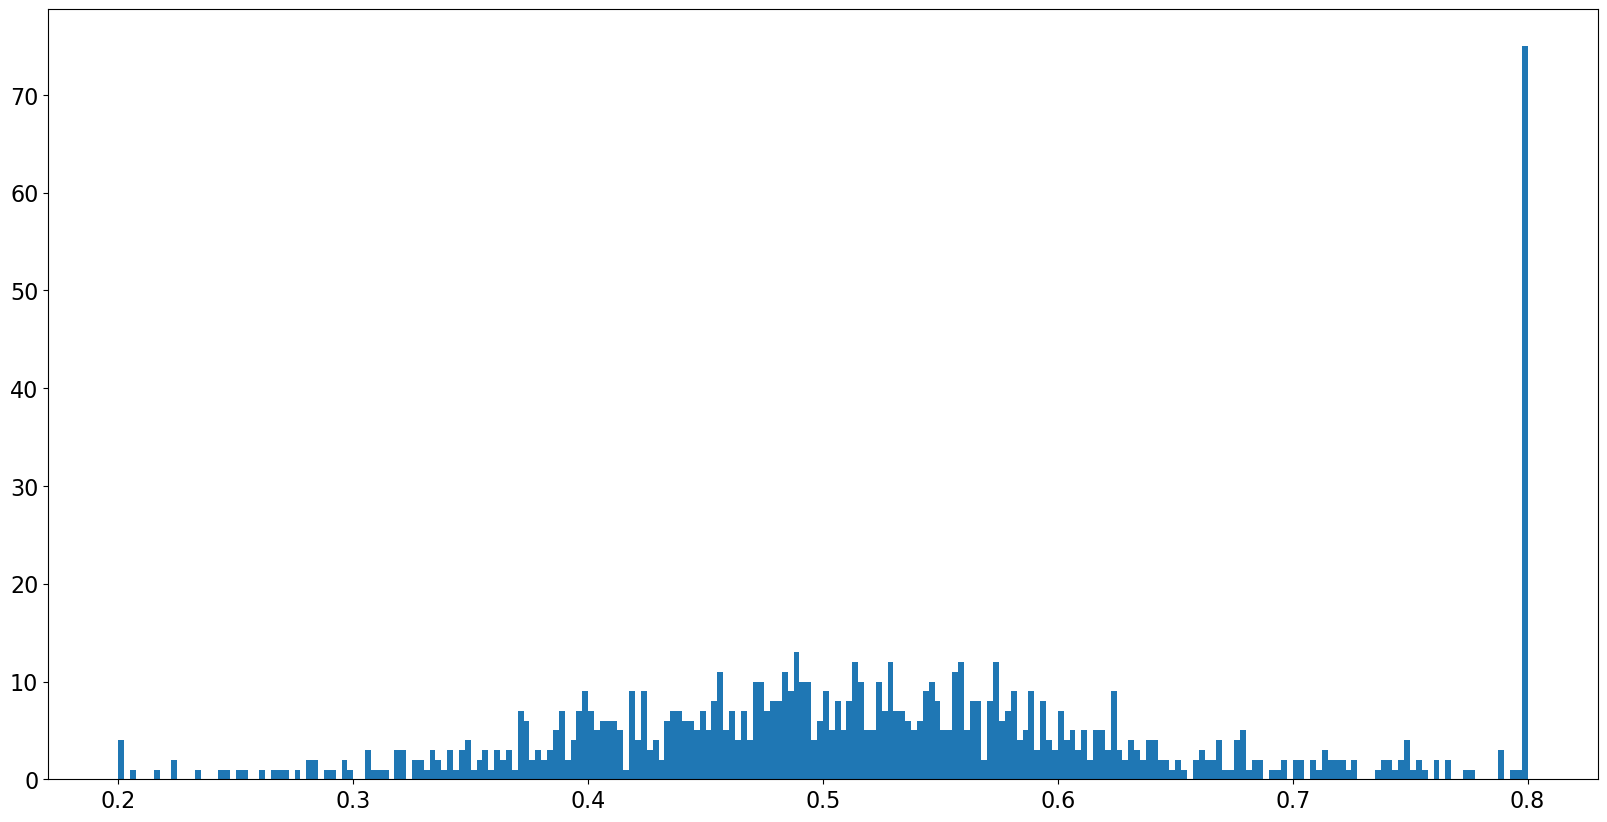

In [15]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist(ks_adj.values(), bins=240)

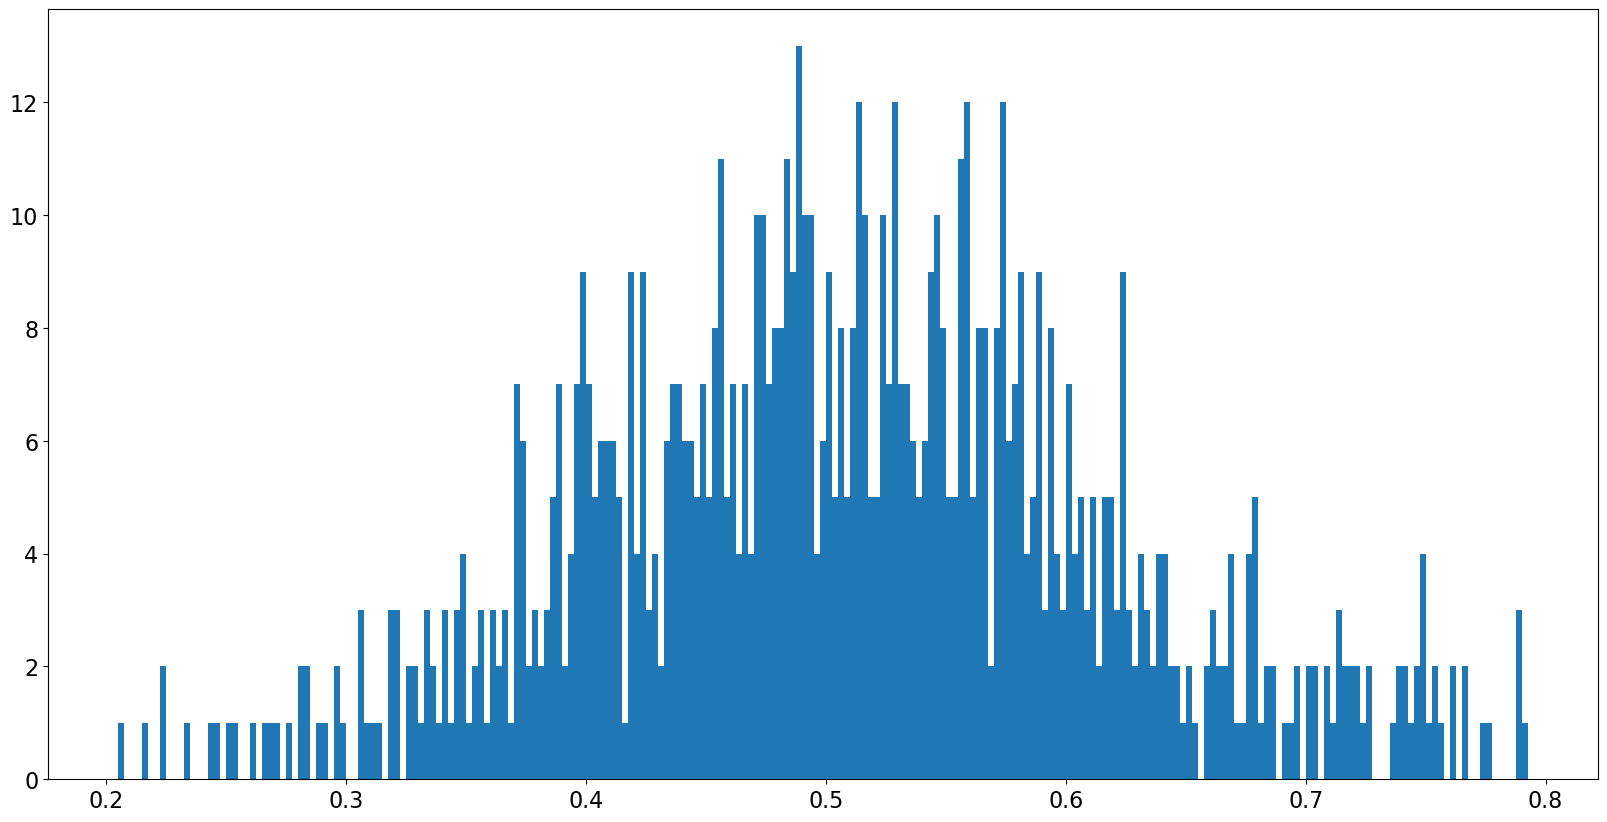

In [16]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist([ x for x in ks_adj.values() if x > 0.20251 and x < 0.795 ], bins=235)

(0.5050190398142043, 0.003761077475545994, -0.10263454827485849)

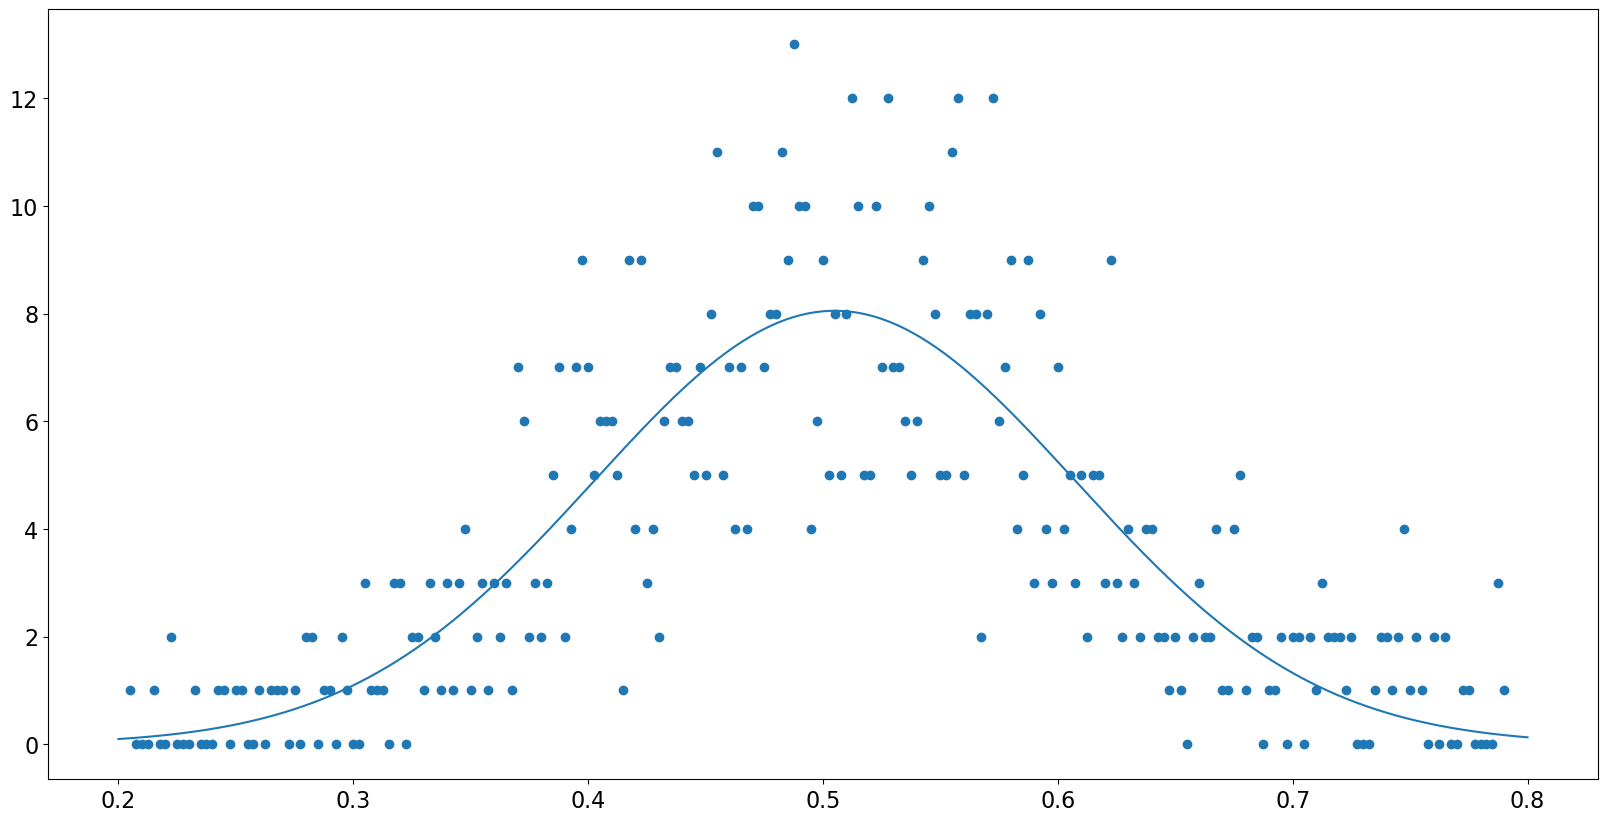

In [25]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins_adj[:-1], counts_adj, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins_adj[:-1], counts_adj)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [17]:
bins_adj

array([0.205 , 0.2075, 0.21  , 0.2125, 0.215 , 0.2175, 0.22  , 0.2225,
       0.225 , 0.2275, 0.23  , 0.2325, 0.235 , 0.2375, 0.24  , 0.2425,
       0.245 , 0.2475, 0.25  , 0.2525, 0.255 , 0.2575, 0.26  , 0.2625,
       0.265 , 0.2675, 0.27  , 0.2725, 0.275 , 0.2775, 0.28  , 0.2825,
       0.285 , 0.2875, 0.29  , 0.2925, 0.295 , 0.2975, 0.3   , 0.3025,
       0.305 , 0.3075, 0.31  , 0.3125, 0.315 , 0.3175, 0.32  , 0.3225,
       0.325 , 0.3275, 0.33  , 0.3325, 0.335 , 0.3375, 0.34  , 0.3425,
       0.345 , 0.3475, 0.35  , 0.3525, 0.355 , 0.3575, 0.36  , 0.3625,
       0.365 , 0.3675, 0.37  , 0.3725, 0.375 , 0.3775, 0.38  , 0.3825,
       0.385 , 0.3875, 0.39  , 0.3925, 0.395 , 0.3975, 0.4   , 0.4025,
       0.405 , 0.4075, 0.41  , 0.4125, 0.415 , 0.4175, 0.42  , 0.4225,
       0.425 , 0.4275, 0.43  , 0.4325, 0.435 , 0.4375, 0.44  , 0.4425,
       0.445 , 0.4475, 0.45  , 0.4525, 0.455 , 0.4575, 0.46  , 0.4625,
       0.465 , 0.4675, 0.47  , 0.4725, 0.475 , 0.4775, 0.48  , 0.4825,
      

(array([68.,  8.,  6.,  6.,  1.,  5.,  7.,  1.,  2.,  1.,  3.,  1.,  0.,
         2.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 ]),
 <BarContainer object of 20 artists>)

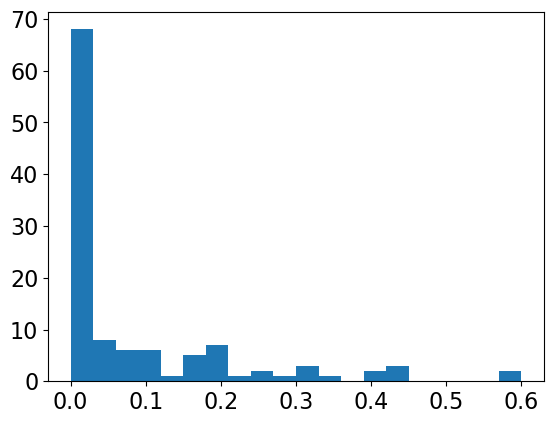

In [20]:
plt.hist(list({ gid: ks_hr[gid] - ks_adj[gid] for gid in ks_hr.keys() if np.abs(ks_hr[gid]) > 0.8 }.values()), bins=20)

(array([  1.,   0.,   1.,   1.,   0.,   2.,   5.,  11.,  11.,   7.,   7.,
          8.,  28.,  45., 129., 227., 205., 103.,  54.,  18.,  12.,  11.,
          5.,   6.,   6.,   4.,   3.,   2.,   1.,   1.]),
 array([0.50482386, 0.5368825 , 0.56894114, 0.60099978, 0.63305841,
        0.66511705, 0.69717569, 0.72923433, 0.76129296, 0.7933516 ,
        0.82541024, 0.85746888, 0.88952751, 0.92158615, 0.95364479,
        0.98570342, 1.01776206, 1.0498207 , 1.08187934, 1.11393797,
        1.14599661, 1.17805525, 1.21011389, 1.24217252, 1.27423116,
        1.3062898 , 1.33834844, 1.37040707, 1.40246571, 1.43452435,
        1.46658299]),
 <BarContainer object of 30 artists>)

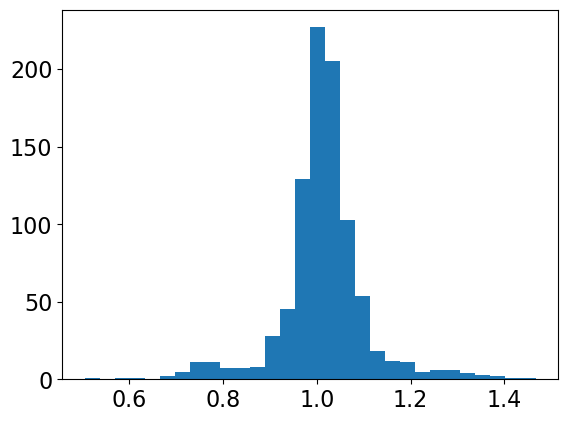

In [21]:
plt.hist([ x for x in qs_hr.values() if abs(x-1) < 0.5], bins=30)

In [22]:
ks_adj

{2542246912654630912: 0.6000000000000003,
 2689854321458250112: 0.3850000000000002,
 2500641186499915392: 0.3050000000000001,
 2686850112096922368: 0.5200000000000002,
 2541998766623853184: 0.4400000000000002,
 3263125837205951872: 0.4000000000000002,
 2686240123658296192: 0.5100000000000002,
 3256467332228378624: 0.3950000000000002,
 3267690425368759680: 0.8000000000000005,
 2693482636814536576: 0.25000000000000006,
 2506564938538312960: 0.35250000000000015,
 2677612324634274176: 0.45000000000000023,
 4227003188048533888: 0.8000000000000005,
 2679977683383222656: 0.22250000000000003,
 2535815796128392448: 0.2,
 5187724218963904256: 0.5450000000000004,
 2542478806528953600: 0.48250000000000026,
 2510512666318224640: 0.8000000000000005,
 2508625732566432512: 0.3175000000000001,
 2494655750140354048: 0.8000000000000005,
 2538007328960080640: 0.44500000000000023,
 2677157088165139584: 0.34750000000000014,
 3265446528294787968: 0.4950000000000003,
 2506627443197595648: 0.47000000000000025,

In [23]:
qs_adj

{2542246912654630912: 1.0006366312133717,
 2689854321458250112: 1.0000624017454887,
 2500641186499915392: 1.0004091666307466,
 2686850112096922368: 1.0003178624656646,
 2541998766623853184: 1.0000213477561226,
 3263125837205951872: 1.001734100187774,
 2686240123658296192: 0.9999677326903917,
 3256467332228378624: 0.9999687828431645,
 3267690425368759680: 1.0,
 2693482636814536576: 0.9999999999999999,
 2506564938538312960: 1.00523582353774,
 2677612324634274176: 1.0000375918476652,
 4227003188048533888: 1.0006398420826674,
 2679977683383222656: 1.0000490792952674,
 2535815796128392448: 1.0,
 5187724218963904256: 1.0000212733786946,
 2542478806528953600: 0.9999987816202215,
 2510512666318224640: 1.0,
 2508625732566432512: 1.0001260464014123,
 2494655750140354048: 1.0,
 2538007328960080640: 1.0000684985933768,
 2677157088165139584: 1.0000203940600276,
 3265446528294787968: 0.999988502418748,
 2506627443197595648: 1.0020177660026393,
 5187816126968839424: 0.9999678596294044,
 2641023940620